In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
nltk.download("stopwords")
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor 
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# фиксируем random_seed для воспроизводимости

# Kaggle
#DIR_TEST  = '../input/sf-dst-car-price-prediction/' 
#DIR_TRAIN   = '../input/all-auto-ru-09-09-2020/'
#train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv')
#test = pd.read_csv(DIR_TEST + 'test.csv')
#submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Local
PATH = 'drive/MyDrive/Skillfactory Project5/'
train = pd.read_csv(PATH+'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(PATH+'test.csv')
submission = pd.read_csv(PATH+'sample_submission.csv')

RANDOM_SEED = 42
NOWDAYS = 2020
VAL_SIZE   = 0.2

In [3]:
display(train.head(2))
test.head(2)

bodyType brand   color fuelType  ...     price            start_date  hidden  model
0    Седан  AUDI  040001   бензин  ...  200000.0  2019-10-03T08:09:11Z     NaN    100
1    Седан  AUDI  EE1D19   бензин  ...   60000.0  2020-09-06T06:49:40Z     NaN    100

[2 rows x 26 columns]

bodyType  brand  ...           Состояние     Таможня
0  лифтбек  SKODA  ...  Не требует ремонта  Растаможен
1  лифтбек  SKODA  ...  Не требует ремонта  Растаможен

[2 rows x 32 columns]

In [4]:
print(f'{train.info()}, {test.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

## Сравнение датасетов перед слиянием

In [5]:
# Количество дупликатов в трейне

train.duplicated().sum()

2114

In [6]:
# Удалим дупликаты

train.drop_duplicates(inplace=True)

Видим, что в тренировочном и тестовом датасетах разное количество фичей и разные типы данных. Создадим функцию для сравнения датасетов друг с другом

In [7]:
def check_dfs(df_1, df_2):
    '''
    Данная функция сравнивает между собой два датасета 
    по типам данных признаков и количеству уникальных значений
    '''

    columns_1, columns_2 = list(df_1.columns), list(df_2.columns)
    train_dict, test_dict = {}, {}
    train_dict['train_feats'], test_dict['test_feats'] = columns_1, columns_2
    train_dict['train_types'], test_dict['test_types'] = df_1.dtypes, df_2.dtypes
    train_dict['train_sample'], test_dict['test_sample'] = df_1.loc[10].values, df_2.loc[10].values
    train_dict['nunique_train'], test_dict['nunique_test'] = df_1.nunique().values, df_2.nunique().values

    train_df, test_df = pd.DataFrame.from_dict(train_dict), pd.DataFrame.from_dict(test_dict)
    df_insert = pd.DataFrame(columns=['< - >'])
    check_df = pd.concat([train_df, df_insert, test_df], axis=1)
    check_df.reset_index(inplace=True)
    check_df['< - >'] = '| - |'
    del check_df['index']
    display(check_df)

    temp_dict = {}
    list_1, list_2, list_3, list_4, list_5 = [], [], [], [], []

    for i in range(len(check_df)):
        if str(check_df['train_types'][i]) != str(check_df['test_types'][i]):
            list_1.append(check_df['train_feats'][i])
            list_2.append(check_df['test_feats'][i])
            list_3.append(str(check_df['train_types'][i]) + ' != ' + str(check_df['test_types'][i]))
            list_4.append(i)
        if check_df['nunique_test'][i]>0 and check_df['nunique_train'][i] != check_df['nunique_test'][i]:
            list_5.append(i)
    temp_dict['index'] = list_4
    temp_dict['train_feats'] = list_1
    temp_dict['не совпадают типы'] = list_3
    temp_dict['test_feats'] = list_2
    temp_df = pd.DataFrame.from_dict(temp_dict)
    temp_df.set_index('index', inplace=True)
    print(f'Резюме:\n1. Не совпали типы в:= {len(temp_df)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(list_5)} столбцах {list_5}')
    display(temp_df)

In [8]:
check_dfs(train, test)

train_feats  ... nunique_test
0               bodyType  ...         24.0
1                  brand  ...         12.0
2                  color  ...         16.0
3               fuelType  ...          5.0
4              modelDate  ...         66.0
5                   name  ...       2780.0
6          numberOfDoors  ...          5.0
7         productionDate  ...         69.0
8   vehicleConfiguration  ...        634.0
9    vehicleTransmission  ...          4.0
10    engineDisplacement  ...         55.0
11           enginePower  ...        315.0
12           description  ...      31732.0
13               mileage  ...      11268.0
14          Комплектация  ...          NaN
15                Привод  ...          3.0
16                  Руль  ...          2.0
17             Состояние  ...          1.0
18             Владельцы  ...          3.0
19                   ПТС  ...          2.0
20               Таможня  ...          1.0
21              Владение  ...        275.0
22                 price  ...          NaN
23            start_date  ...          NaN
24                hidden  ...          NaN
25                 model  ...          NaN
26                   NaN  ...      34686.0
27                   NaN  ...       2364.0
28                   NaN  ...      23705.0
29                   NaN  ...      34557.0
30                   NaN  ...        954.0
31                   NaN  ...        544.0
32                   NaN  ...      34686.0
33                   NaN  ...          1.0
34                   NaN  ...      34686.0
35                   NaN  ...       5890.0
36                   NaN  ...          2.0

[37 rows x 9 columns]

Резюме:
1. Не совпали типы в:= 22 столбцах

2. Уникальные значения различаются в:= 24 столбцах [0, 1, 3, 4, 5, 7, 8, 10, 11, 12, 13, 17, 21, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


train_feats  не совпадают типы          test_feats
index                                                      
4          modelDate   float64 != int64           modelDate
6      numberOfDoors   float64 != int64       numberOfDoors
11       enginePower  float64 != object         enginePower
14      Комплектация      object != nan                 NaN
17         Состояние  float64 != object           Состояние
18         Владельцы  float64 != object           Владельцы
20           Таможня     bool != object             Таможня
22             price     float64 != nan                 NaN
23        start_date      object != nan                 NaN
24            hidden     float64 != nan                 NaN
25             model      object != nan                 NaN
26               NaN      nan != object             car_url
27               NaN      nan != object  complectation_dict
28               NaN      nan != object      equipment_dict
29               NaN      nan != object               image
30               NaN      nan != object          model_info
31               NaN      nan != object          model_name
32               NaN       nan != int64    parsing_unixtime
33               NaN      nan != object       priceCurrency
34               NaN       nan != int64             sell_id
35               NaN      nan != object           super_gen
36               NaN      nan != object              vendor

После запуска выявили список столбцов, не полезных в дальнейшей работе.
Это признаки, имеющие единственное значение, признаки не имеющие пары в обучающем и тестовом датасетах, признаки,содержащие консолидированную информацию, уже сохраненную в других признаках.
Некоторые признаки следует рассмотреть отдельно.



In [9]:
# Признак model в train и model_name в test

print(train.model.value_counts())
print()
print(test.model_name.value_counts())

# Оба данных признака содержат информацию о названии модели авто.
# Переведем все значения в нижний регистр и переименуем столбец в тренировочном датасете в model_name

train.rename(columns={'model':'model_name'}, inplace=True)
train.model_name = train.model_name.str.lower()
test.model_name = test.model_name.str.lower()

print(train.model_name.value_counts())
print()
print(test.model_name.value_counts())

FOCUS          2464
SOLARIS        1686
5ER            1643
ASTRA          1545
RIO            1449
               ... 
COUGAR            1
GRAND_HIACE       1
TRAVIQ            1
CTS_V             1
120               1
Name: model, Length: 1086, dtype: int64

OCTAVIA        1418
5ER            1026
LANCER          855
E_KLASSE        809
PASSAT          782
               ... 
W136              1
VELLFIRE          1
YARIS_VERSO       1
I8                1
VIGOR             1
Name: model_name, Length: 544, dtype: int64
focus      2464
solaris    1686
5er        1643
astra      1545
rio        1449
           ... 
fr_v          1
viper         1
dokker        1
kix           1
quest         1
Name: model_name, Length: 1086, dtype: int64

octavia      1418
5er          1026
lancer        855
e_klasse      809
passat        782
             ... 
president       1
e3              1
fto             1
aygo            1
presea          1
Name: model_name, Length: 544, dtype: int64


In [10]:
# Признаки сomplectation_dict, equipment_dict и Комплектация

print(train['Комплектация'].value_counts())
print()
print(test.complectation_dict.value_counts())
print()
print(f'Количество пропусков в столбце Комплектация {train["Комплектация"].isna().sum()}')
print()
print(f'Количество пропусков в столбце complectation_dict {test.complectation_dict.isna().sum()}')
print()

# Подставим вместо пропущенных значений в тестовом признаке заглушку из тренировочного датасета
# Переименуем тренировочный признак в complectation_dict

test.complectation_dict.fillna(train["Комплектация"].value_counts().index[0], inplace=True)
train.rename(columns={'Комплектация':'complectation_dict'}, inplace=True)

print(f'Количество пропусков в столбце complectation_dict после замены NaN {test.complectation_dict.isna().sum()}')
print()
print(train.columns)

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [11]:
cols_to_drop = ['Состояние', 'Таможня', 'car_url', 'equipment_dict', 'image', 
                'model_info', 'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vendor', 'hidden', 'start_date']
                
for col in cols_to_drop:
    if col in list(train.columns):
        train.drop(columns=col, inplace=True)
    if col in list(test.columns):
        test.drop(columns=col, inplace=True)

In [12]:
# Определим наличие новых дупликатов после удаление колонок

train.duplicated().sum()

1463

In [13]:
# Удалим дупликаты

train.drop_duplicates(inplace=True)

In [14]:
check_dfs(train, test)

train_feats  ... nunique_test
0               bodyType  ...         24.0
1                  brand  ...         12.0
2                  color  ...         16.0
3               fuelType  ...          5.0
4              modelDate  ...         66.0
5                   name  ...       2780.0
6          numberOfDoors  ...          5.0
7         productionDate  ...         69.0
8   vehicleConfiguration  ...        634.0
9    vehicleTransmission  ...          4.0
10    engineDisplacement  ...         55.0
11           enginePower  ...        315.0
12           description  ...      31732.0
13               mileage  ...      11268.0
14    complectation_dict  ...       2365.0
15                Привод  ...          3.0
16                  Руль  ...          2.0
17             Владельцы  ...          3.0
18                   ПТС  ...          2.0
19              Владение  ...        275.0
20                 price  ...          NaN
21            model_name  ...        544.0

[22 rows x 9 columns]

Резюме:
1. Не совпали типы в:= 5 столбцах

2. Уникальные значения различаются в:= 14 столбцах [0, 1, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 19, 21]


train_feats  не совпадают типы     test_feats
index                                                 
4          modelDate   float64 != int64      modelDate
6      numberOfDoors   float64 != int64  numberOfDoors
11       enginePower  float64 != object    enginePower
17         Владельцы  float64 != object      Владельцы
20             price     float64 != nan            NaN

### Приведение признаков тренировочного к формату из тестового датасета

Признаки с несоответсвием типов данных (modelDate, numberOfDoors, enginePower, Владельцы)

In [15]:
train.isna().sum()

bodyType                    1
brand                       0
color                       0
fuelType                    0
modelDate                   1
name                        1
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
engineDisplacement          1
enginePower                 1
description              3232
mileage                     0
complectation_dict          0
Привод                      1
Руль                        0
Владельцы               10554
ПТС                       348
Владение                56807
price                     410
model_name                  0
dtype: int64

Вероятно есть строка с одними пропусками, проверим данную теорию

In [16]:
train.dropna(subset=['modelDate']).isna().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
engineDisplacement          0
enginePower                 0
description              3232
mileage                     0
complectation_dict          0
Привод                      0
Руль                        0
Владельцы               10554
ПТС                       348
Владение                56806
price                     410
model_name                  0
dtype: int64

Теория оказалась верна, удаляем данную строку вместе со строками, где не спарсилась цена (наш таргет).

In [17]:
train.dropna(subset=['modelDate', 'price'], inplace=True)

In [18]:
# float != int несоответствие

cols_to_int = ['modelDate', 'numberOfDoors']
for col in cols_to_int:
    train[col] = train[col].astype('int')

cols_to_object = ['enginePower', 'Владельцы']
for col in cols_to_object:
    train[col] = train[col].astype('object')

Признак bodyType

In [19]:
print(train.bodyType.unique()[:10])
print(test.bodyType.unique()[:10])

['Седан' 'Универсал 5 дв.' 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.'
 'Хэтчбек 5 дв.' 'Кабриолет' 'Купе' 'Лифтбек Sportback' 'Лифтбек'
 'Седан Long']
['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет']


In [20]:
# Пока что просто сменим регистр в тренировочном датасете на нижний

train['bodyType'] = train.bodyType.str.lower()

print(train.bodyType.unique()[:10])

['седан' 'универсал 5 дв.' 'хэтчбек 5 дв. sportback' 'хэтчбек 3 дв.'
 'хэтчбек 5 дв.' 'кабриолет' 'купе' 'лифтбек sportback' 'лифтбек'
 'седан long']


Признак *color*

In [21]:
print(train.color.unique())
print(test.color.unique())

['040001' 'EE1D19' '0000CC' 'CACECB' '007F00' 'FAFBFB' '97948F' '22A0F8'
 '660099' '200204' 'C49648' 'DEA522' '4A2197' 'FFD600' 'FF8649' 'FFC0CB']
['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']


In [22]:
# В тренировочном сете цвета представлены в HEX формате, переведем их в формат тестового датасета

color_map = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый',
             '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый',
             '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 'FFC0CB':'розовый'}
train['color'] = train.color.map(color_map)

Признак vehicleTransmission

In [23]:
print(train.vehicleTransmission.unique())
print(test.vehicleTransmission.unique())

['MECHANICAL' 'AUTOMATIC' 'ROBOT' 'VARIATOR']
['роботизированная' 'механическая' 'автоматическая' 'вариатор']


In [24]:
# Просто переведем данные в формат теста

transmission_map = {'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
train['vehicleTransmission'] = train.vehicleTransmission.map(transmission_map)

print(train.vehicleTransmission.unique())

['механическая' 'автоматическая' 'роботизированная' 'вариатор']


Признак engineDisplacement

In [25]:
print(train.engineDisplacement.unique())
print(test.engineDisplacement.unique())

['2.8' '1.8' '2.3' '2.0' '2.6' '2.2' 'S4' '2.0d' '2.5d' '1.9' '2.1' '2.4'
 '1.6' '1.9d' '1.6d' '1.3' '3.3' '1.4' '1.2d' 'ultra' '1.2' '3.2' '1.5'
 '8V' '3.1' '3.0d' '2.7d' '16V' '3.0' '7S-tronic' 'tiptronic' '40' '45'
 '55' '2.7' '4.2' 'S-tronic' 'Tiptronic' 'Long' '4.0' '60' '3.9d' '6.0'
 '3.7' '4.1d' '35' '8tiptronic' 'clean' '2.0hyb' '3.6' '5.9d' 'V10' 'V8'
 '2.5' '2.9' '5.0' '5.2' 'M135i' '116i' '120i' '118i' '135i' 'M140i'
 '125i' '120d' '130i' '118d' '218i' '220i' '220d' 'M235i' '218d' '216d'
 '335i' '320i' '318i' '318d' '320d' '316i' '328i' '330i' '325xi' '325i'
 '330d' '340i' '323i' '335d' '335xi' '330xi' '316' '315' '318' 'N46'
 '420d' '428i' '420i' '435i' '430i' '440i' '520d' '530d' '525i' '523i'
 '520i' '530i' '525d' '528i' '550i' '535d' 'M550i' 'M550d' '540i' '535i'
 '530xi' '530Li' '525xi' '518' '520Li' '528Li' '535xi' '545i' '524d'
 '518i' '535Li' '530xd' '630i' '640i' '650i' '640d' '630d' '620d' '635i'
 '645i' '750d' '740i' '730Ld' '750i' '750Li' '740Li' '730d' '730i' '7

Полный бардак.. попробуем вытащить объем двигателя их столбца name с помощью регулярных выражений

In [26]:
def displacement_from_name(row):
    row = str(row)
    result = re.findall('\d\.\d', row)
    if result == []:
        return None
    return result[0]

# создадим переменную куда сохраним старый признак "на всякий случай" и перезапишем данный в столбец при помощи нашей функции

train.rename(columns={'engineDisplacement':'engineDisplacement2'}, inplace=True)
engineDisplacementOld = train['engineDisplacement2']
train['engineDisplacement'] = train['name'].apply(displacement_from_name)

In [27]:
print(train.engineDisplacement.unique())

['2.8' '1.8' '2.3' '2.0' '2.6' '2.2' '2.5' '1.9' '2.1' '2.4' '1.6' '1.3'
 '3.3' '1.4' '1.2' '3.2' '1.5' '3.1' '3.0' '2.7' '4.2' '4.0' '3.9' '6.3'
 '6.0' '3.7' '4.1' None '3.6' '5.9' '5.2' '2.9' '5.0' '1.7' '4.4' '3.4'
 '3.5' '4.8' '5.4' '6.6' '0.7' '4.9' '4.6' '6.2' '4.5' '6.4' '8.2' '5.3'
 '5.7' '7.0' '1.1' '0.8' '4.3' '8.1' '6.7' '3.8' '1.0' '7.5' '7.4' '6.5'
 '6.1' '6.8' '4.7' '8.4' '5.8' '7.3' '5.6' '5.5' '0.0']


In [28]:
# В качестве исключения изменим test значения убрав 'LTR'

test['engineDisplacement'] = test.engineDisplacement.apply(lambda x: np.nan if x == ' LTR' else x.split(' ')[0])

Признак *Руль*

In [29]:
print(train['Руль'].unique())
print(test['Руль'].unique())

['LEFT' 'RIGHT']
['Левый' 'Правый']


In [30]:
# Просто переведем данные в формат теста

wheel_map = {'LEFT':'Левый', 'RIGHT':'Правый'}
train['Руль'] = train['Руль'].map(wheel_map)

print(train['Руль'].unique())

['Левый' 'Правый']


Признак *ПТС*

In [31]:
print(train['ПТС'].unique())
print(test['ПТС'].unique())

['ORIGINAL' 'DUPLICATE' nan]
['Оригинал' 'Дубликат' nan]


In [32]:
# Просто переведем данные в формат теста

pts_map = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
train['ПТС'] = train['ПТС'].map(pts_map)

print(train['ПТС'].unique())

['Оригинал' 'Дубликат' nan]


Признак *Владельцы*

In [33]:
print(train['Владельцы'].unique())
print(test['Владельцы'].unique())

[3.0 1.0 2.0 nan]
['3 или более' '1\xa0владелец' '2\xa0владельца']


In [34]:
# Просто переведем данные в формат теста

own_map = {3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'}
train['Владельцы'] = train['Владельцы'].map(own_map)

print(train['Владельцы'].unique())

['3 или более' '1\xa0владелец' '2\xa0владельца' nan]


Признак enginePower

In [35]:
print(train['enginePower'].unique()[:10])
print(test['enginePower'].unique()[:10])

[174.0 90.0 136.0 101.0 133.0 150.0 115.0 137.0 112.0 230.0]
['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12']


In [36]:
# Просто переведем данные в формат теста

train['enginePower'] = train['enginePower'].apply(lambda x: str(int(x))+' N12')

print(train['enginePower'].unique()[:10])

['174 N12' '90 N12' '136 N12' '101 N12' '133 N12' '150 N12' '115 N12'
 '137 N12' '112 N12' '230 N12']


Признаки *fuelType, name, productionDate, vehicleConfiguration, description, mileage, Привод, Владение* по первому взгляду на таблицу не вызвали сомнений. Проверим их отдельно на всякий случай


In [37]:
print(f'brand train: {train.brand.unique()}\n')
print(f'brand test: {test.brand.unique()}\n')
print()
print(f'fuelType train: {train.fuelType.unique()}\n')
print(f'fuelType test: {test.fuelType.unique()}\n')
print()
print(f'name train: {train.name.unique()}\n')
print(f'name test: {test.name.unique()}\n')
print()
print(f'productionDate train: {train.productionDate.unique()}\n')
print(f'productionDate test: {test.productionDate.unique()}\n')
print()
print(f'vehicleConfiguration train:\n{train.vehicleConfiguration.sample(5)}\n')
print(f'vehicleConfiguration test:\n{test.vehicleConfiguration.sample(5)}\n')
print()
print(f'description train:\n{train.description.sample(5)}\n')
print(f'description test:\n{test.description.sample(5)}\n')
print()
print(f'mileage train:\n{train.mileage.sample(5)}\n')
print(f'mileage test:\n{test.mileage.sample(5)}\n')
print()
print(f'Привод train: {train["Привод"].unique()}\n')
print(f'Привод test: {test["Привод"].unique()}\n')
print()
print(f'Владение train:\n{train["Владение"].sample(5)}\n')
print(f'Владение test:\n{test["Владение"].sample(5)}\n')

brand train: ['AUDI' 'BMW' 'CADILLAC' 'CHERY' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO'
 'DODGE' 'FORD' 'GEELY' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA'
 'LEXUS' 'MAZDA' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL' 'PEUGEOT' 'PORSCHE'
 'RENAULT' 'SKODA' 'SUBARU' 'SUZUKI' 'TOYOTA' 'VOLKSWAGEN' 'VOLVO'
 'GREAT_WALL' 'LAND_ROVER' 'MERCEDES' 'SSANG_YONG']

brand test: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


fuelType train: ['бензин' 'дизель' 'электро' 'гибрид' 'газ']

fuelType test: ['бензин' 'дизель' 'гибрид' 'электро' 'газ']


name train: ['2.8 MT (174 л.с.) 4WD' '1.8 MT (90 л.с.)' '2.3 MT (136 л.с.) 4WD' ...
 '2.3 AT (140 л.с.)' '2.9d AT (132 л.с.) 4WD' '2.7d AT (165 л.с.) 4WD']

name test: ['1.2 AMT (105 л.с.)' '1.6 MT (110 л.с.)' 'DSG 1.8 AMT (152 л.с.)' ...
 'Arctic Trucks AT38 2.8d AT (177 л.с.) 4WD' '2.0 MT (151 л.с.) 4WD'
 '300 3.0 AT (218 л.с.)']


productionDate train: [1991 1986 1989 1993 1992 1994 198

Кроме "Владение" все признаки в норме. Признак Владение в train представляет из себя словарь, в то время как в test это просто строковое описание. Пока что оставим до отдельного анализа

Таргет признак *price*

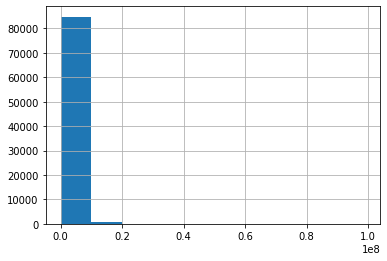

In [38]:
train.price.hist()

In [39]:
train.price.describe()

count    8.539000e+04
mean     1.238098e+06
std      1.921640e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.300000e+05
75%      1.350000e+06
max      9.900000e+07
Name: price, dtype: float64

In [40]:
# из-за большого разбега по стоимости возьмем логарифм от цены

train['price_log'] = np.log(train.price)

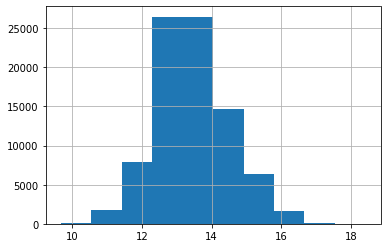

In [41]:
train.price_log.hist()

Финальное сравнение датасетов

In [42]:
check_dfs(train, test)

train_feats  ... nunique_test
0               bodyType  ...         24.0
1                  brand  ...         12.0
2                  color  ...         16.0
3               fuelType  ...          5.0
4              modelDate  ...         66.0
5                   name  ...       2780.0
6          numberOfDoors  ...          5.0
7         productionDate  ...         69.0
8   vehicleConfiguration  ...        634.0
9    vehicleTransmission  ...          4.0
10   engineDisplacement2  ...          NaN
11           enginePower  ...        315.0
12           description  ...      31732.0
13               mileage  ...      11268.0
14    complectation_dict  ...       2365.0
15                Привод  ...          3.0
16                  Руль  ...          2.0
17             Владельцы  ...          3.0
18                   ПТС  ...          2.0
19              Владение  ...        275.0
20                 price  ...          NaN
21            model_name  ...        544.0
22    engineDisplacement  ...         54.0
23             price_log  ...          NaN

[24 rows x 9 columns]

Резюме:
1. Не совпали типы в:= 3 столбцах

2. Уникальные значения различаются в:= 13 столбцах [0, 1, 4, 5, 7, 8, 11, 12, 13, 14, 19, 21, 22]


train_feats не совпадают типы  test_feats
index                                                   
10     engineDisplacement2     object != nan         NaN
20                   price    float64 != nan         NaN
23               price_log    float64 != nan         NaN

Типы данных не совпали лишь в трех признаках:

1. Таргет признак price и его логарифм
2. Созданная нами копия старого признака engineDisplacement

# Слияние и предварительный анализ датасета

In [43]:
# Создадим признак для разделения датасетов

train['train'] = 1 # Здесь у нас тренировочный датасет
test['train'] = 0  # А тут тестовый

# Объединим наши датасеты

df = train.append(test, sort=False).reset_index(drop=True)

In [44]:
# Проверим после слияния 

df.sample(3)

bodyType brand   color  ... engineDisplacement  price_log train
96053              седан   BMW  чёрный  ...                3.0        NaN     0
10254  внедорожник 5 дв.   BMW  чёрный  ...                3.0   14.79007     1
33776              седан   KIA   белый  ...                3.8   13.81451     1

[3 rows x 25 columns]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120076 entries, 0 to 120075
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              120076 non-null  object 
 1   brand                 120076 non-null  object 
 2   color                 120076 non-null  object 
 3   fuelType              120076 non-null  object 
 4   modelDate             120076 non-null  int64  
 5   name                  120076 non-null  object 
 6   numberOfDoors         120076 non-null  int64  
 7   productionDate        120076 non-null  int64  
 8   vehicleConfiguration  120076 non-null  object 
 9   vehicleTransmission   120076 non-null  object 
 10  engineDisplacement2   85390 non-null   object 
 11  enginePower           120076 non-null  object 
 12  description           116864 non-null  object 
 13  mileage               120076 non-null  int64  
 14  complectation_dict    120076 non-null  object 
 15  

In [46]:
df.isna().sum()

bodyType                    0
brand                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
engineDisplacement2     34686
enginePower                 0
description              3212
mileage                     0
complectation_dict          0
Привод                      0
Руль                        0
Владельцы               10535
ПТС                       349
Владение                79243
price                   34686
model_name                  0
engineDisplacement        161
price_log               34686
train                       0
dtype: int64

В данный момент не будем расписывать, какой признак к какой категории принадлежит. Сделаем это после отдельного анализа каждого из них и добавления новых фичей.
На первый взгляд по признакам:
1. В признаке bodyType тренировочного датасета слишком много значений, в которых упоминается либо модель, либо количество дверей. Возможно имеет смысл обобщить значения, убрав лишнюю информацию, которая уже присутствует в виде других признаков.
2. Во многих признаках из трениовочного датасета количество значений выше, чем в тестовом. Возможно для улучшения работы модели потребуется обобщать значения, выходящие за рамки тестового датасета (хотя в моем случае это не желательно, так как я пытаюсь сделать именно воспоизводимую модель с разными данными, а не только с теми, что есть в тесте).

# EDA And Feature Engineering

In [47]:
# Составим функцию для предварительного анализа каждого признака

def col_info(col):
    print('Количество пропусков: {}\n'.format(col.isna().sum()))
    print('{}\n'.format(col.describe()))
    print('Распределение:\n{}\n'.format(col.value_counts()))

In [48]:
# Создадим списки с типами наших значений, куда будем отправлять каждый из признаков после анализа

cat_cols = []  # Категориальные признаки
num_cols = []  # Числовые признаки
bin_cols = []  # Бинарные признаки
bool_cols = [] # Логические признаки
ordinal_cat_cols = [] # Категориальные порядковые признаки

## 1. bodyType

In [49]:
col_info(df.bodyType)

Количество пропусков: 0

count     120076
unique       168
top        седан
freq       42871
Name: bodyType, dtype: object

Распределение:
седан                 42871
внедорожник 5 дв.     41646
хэтчбек 5 дв.         10681
лифтбек                5165
универсал 5 дв.        4634
                      ...  
хэтчбек 5 дв. runx        1
хэтчбек 5 дв. long        1
кабриолет jcw             1
седан lwb                 1
хэтчбек 5 дв. eu          1
Name: bodyType, Length: 168, dtype: int64



In [50]:
col_info(df[df.train == 1].bodyType)

Количество пропусков: 0

count     85390
unique      167
top       седан
freq      29724
Name: bodyType, dtype: object

Распределение:
седан                 29724
внедорожник 5 дв.     29418
хэтчбек 5 дв.          8557
универсал 5 дв.        3358
лифтбек                2933
                      ...  
хэтчбек 5 дв. runx        1
хэтчбек 5 дв. long        1
кабриолет jcw             1
седан lwb                 1
хэтчбек 5 дв. eu          1
Name: bodyType, Length: 167, dtype: int64



In [51]:
col_info(df[df.train == 0].bodyType)

Количество пропусков: 0

count     34686
unique       24
top       седан
freq      13147
Name: bodyType, dtype: object

Распределение:
седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
лимузин                        6
седан 2 дв.                    6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64



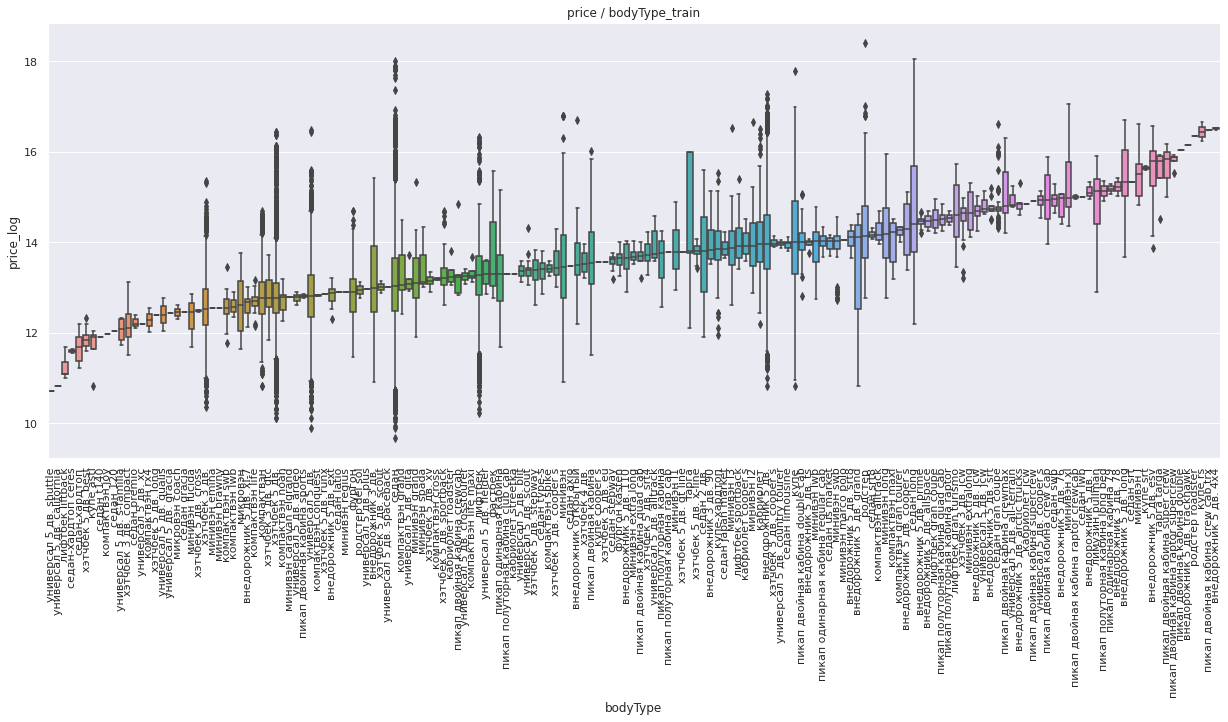

In [52]:
sns.set()
plt.figure(figsize=(21, 8))
order = df[df.train == 1].groupby('bodyType').price_log.median().sort_values().index

g = sns.boxplot(x = 'bodyType', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / bodyType_train')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

Довольно много специфических типов кузова в тренировочной части датасета. Я вижу два варианта развития событий
1. Объединить все типы в отдельные категории без лишней информации (тип дверей, тип кабины). Например: *седан 2 дв.* станет просто *седан*. Таким образом повысится влияние других признаков в работе модели (модель, кол. дверей).
2. Подогнать признаки из тренировочной части под тестовую, а лишние запихать в отдельное значение *Other*
3. Удалить лишние значения, не входящие в тест, после чего либо оставить все как есть, либо сделать действия из пункта 1

Планирую попробовать все варианты и сравнить качество работы модели

**1 Вариант**

С первого взгляда можно заметить, что общее название кузова у всех значений находится первым словом. Проверим данную теорию

In [53]:
# train

print(df[df.train == 1].bodyType.apply(lambda x: x.split(' ')[0]).unique())
print(len(df[df.train == 1].bodyType.apply(lambda x: x.split(' ')[0]).unique()))
print()

# test

print(df[df.train == 0].bodyType.apply(lambda x: x.split(' ')[0]).unique())
print(len(df[df.train == 0].bodyType.apply(lambda x: x.split(' ')[0]).unique()))
print()

# Общий

print(df.bodyType.apply(lambda x: x.split(' ')[0]).unique())
print(len(df.bodyType.apply(lambda x: x.split(' ')[0]).unique()))

['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'купе-хардтоп' 'родстер' 'минивэн' 'пикап' 'тарга'
 'микровэн' 'фастбек' 'седан-хардтоп' 'фургон' 'лимузин']
18

['лифтбек' 'внедорожник' 'хэтчбек' 'седан' 'компактвэн' 'универсал'
 'пикап' 'купе' 'кабриолет' 'минивэн' 'родстер' 'микровэн' 'купе-хардтоп'
 'фастбек' 'тарга' 'лимузин' 'седан-хардтоп' 'фургон']
18

['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'купе-хардтоп' 'родстер' 'минивэн' 'пикап' 'тарга'
 'микровэн' 'фастбек' 'седан-хардтоп' 'фургон' 'лимузин']
18


Никаких лишних значений по типу *2 дв.* мы не получили, а количество уникальных значений в обеих частях одинаково. Отразим данное преобразование на нашем датасете

In [54]:
df['bodyType_1'] = df.bodyType.apply(lambda x: x.split(' ')[0])

print(df['bodyType_1'].unique())
print(len(df['bodyType_1'].unique()))

['седан' 'универсал' 'хэтчбек' 'кабриолет' 'купе' 'лифтбек' 'внедорожник'
 'компактвэн' 'купе-хардтоп' 'родстер' 'минивэн' 'пикап' 'тарга'
 'микровэн' 'фастбек' 'седан-хардтоп' 'фургон' 'лимузин']
18


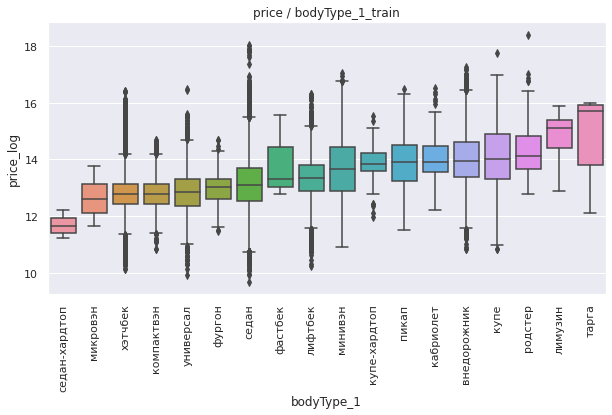

In [55]:
plt.figure(figsize=(10, 5))
order = df[df.train == 1].groupby('bodyType_1').price_log.median().sort_values().index

g = sns.boxplot(x = 'bodyType_1', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / bodyType_1_train')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

**2 Вариант**

In [56]:
bodyType_test = list(df[df.train == 0].bodyType.unique())
bodyType_test

['лифтбек',
 'внедорожник 5 дв.',
 'хэтчбек 5 дв.',
 'седан',
 'компактвэн',
 'универсал 5 дв.',
 'пикап одинарная кабина',
 'хэтчбек 3 дв.',
 'купе',
 'кабриолет',
 'минивэн',
 'пикап двойная кабина',
 'внедорожник 3 дв.',
 'родстер',
 'микровэн',
 'седан 2 дв.',
 'купе-хардтоп',
 'фастбек',
 'тарга',
 'внедорожник открытый',
 'лимузин',
 'пикап полуторная кабина',
 'седан-хардтоп',
 'фургон']

In [57]:
df[df.train == 1].bodyType.apply(lambda x: x if x in bodyType_test else 'другой').unique()

array(['седан', 'универсал 5 дв.', 'другой', 'хэтчбек 3 дв.',
       'хэтчбек 5 дв.', 'кабриолет', 'купе', 'лифтбек',
       'внедорожник 5 дв.', 'седан 2 дв.', 'компактвэн', 'купе-хардтоп',
       'родстер', 'минивэн', 'пикап двойная кабина', 'внедорожник 3 дв.',
       'пикап одинарная кабина', 'тарга', 'пикап полуторная кабина',
       'фастбек', 'микровэн', 'внедорожник открытый', 'седан-хардтоп',
       'фургон'], dtype=object)

Лимузины не попали в конечный список значений хотя присутствуют в тесте. Скорее всего значения принадлежащие лимузинам содержат лишнюю информацию, проверим

In [58]:
df[df.train == 1][df[df.train == 1].bodyType.str.contains('лимузин')]

bodyType     brand   color  ...  price_log  train bodyType_1
83270  лимузин pullman  MERCEDES   синий  ...  15.894952      1    лимузин
83271  лимузин pullman  MERCEDES  чёрный  ...  14.914123      1    лимузин
83281  лимузин pullman  MERCEDES  чёрный  ...  14.220976      1    лимузин
83400  лимузин pullman  MERCEDES  чёрный  ...  15.341567      1    лимузин
83417  лимузин pullman  MERCEDES   белый  ...  12.899220      1    лимузин
83516  лимузин pullman  MERCEDES  чёрный  ...  15.424948      1    лимузин

[6 rows x 26 columns]

Наше предположение оправдалось, проверим данные по лимузинам из теста

In [59]:
df[df.train == 0][df[df.train == 0].bodyType.str.contains('лимузин')]

bodyType     brand   color  ... price_log  train bodyType_1
101352  лимузин  MERCEDES  чёрный  ...       NaN      0    лимузин
102298  лимузин  MERCEDES  чёрный  ...       NaN      0    лимузин
102451  лимузин  MERCEDES  чёрный  ...       NaN      0    лимузин
102945  лимузин  MERCEDES  чёрный  ...       NaN      0    лимузин
117117  лимузин  MERCEDES  чёрный  ...       NaN      0    лимузин
117272  лимузин  MERCEDES   синий  ...       NaN      0    лимузин

[6 rows x 26 columns]

Вышли те же самые лимузины pullman. Необходимо включить данные значения в наш датасет, не относя к значению "другой"

In [60]:
df['bodyType_2'] = df.bodyType.apply(lambda x: x if x in bodyType_test or x == 'лимузин pullman' else 'другой')
df['bodyType_2'] = df.bodyType_2.apply(lambda x: x.split()[0] if x == 'лимузин pullman' else x)

In [61]:
df['bodyType_2'].value_counts()

седан                      42871
внедорожник 5 дв.          41646
хэтчбек 5 дв.              10681
лифтбек                     5165
универсал 5 дв.             4634
другой                      3652
минивэн                     2766
компактвэн                  2381
купе                        2098
хэтчбек 3 дв.               1853
пикап двойная кабина         684
внедорожник 3 дв.            449
купе-хардтоп                 351
родстер                      246
кабриолет                    245
фургон                       211
микровэн                      29
седан-хардтоп                 27
внедорожник открытый          20
пикап полуторная кабина       16
седан 2 дв.                   14
пикап одинарная кабина        14
лимузин                       12
тарга                          7
фастбек                        4
Name: bodyType_2, dtype: int64

In [62]:
print(df['bodyType_2'].unique())
print(len(df['bodyType_2'].unique()))

['седан' 'универсал 5 дв.' 'другой' 'хэтчбек 3 дв.' 'хэтчбек 5 дв.'
 'кабриолет' 'купе' 'лифтбек' 'внедорожник 5 дв.' 'седан 2 дв.'
 'компактвэн' 'купе-хардтоп' 'родстер' 'минивэн' 'пикап двойная кабина'
 'внедорожник 3 дв.' 'пикап одинарная кабина' 'тарга'
 'пикап полуторная кабина' 'фастбек' 'микровэн' 'внедорожник открытый'
 'седан-хардтоп' 'фургон' 'лимузин']
25


In [63]:
df.sample(2)

bodyType    brand   color  ... train  bodyType_1 bodyType_2
118041    седан   NISSAN  чёрный  ...     0       седан      седан
56509     седан  RENAULT  чёрный  ...     1       седан      седан

[2 rows x 27 columns]

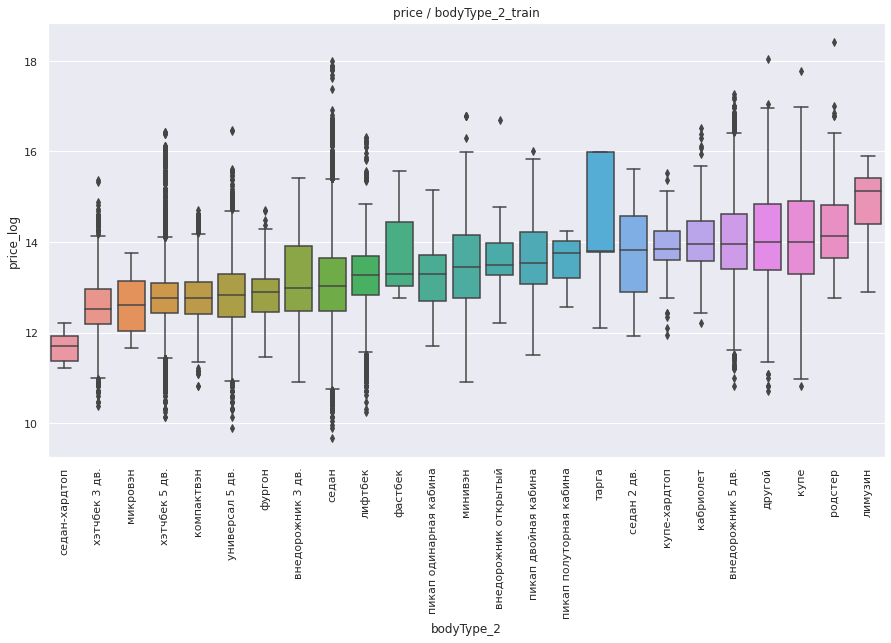

In [64]:
plt.figure(figsize=(15, 8))
order = df[df.train == 1].groupby('bodyType_2').price_log.median().sort_values().index

g = sns.boxplot(x = 'bodyType_2', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / bodyType_2_train')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

Интересно то, что визуально графики для bodyType_1 и bodyType_2 одинаковы за исключением значения *other* и значение тарга во втором случае по медиане находится не так высоко. Возможно удаление  *other* в дальнейшем сможет улучшить работу модели. Оставим это на потом

In [65]:
# Внесем данные признаки в наш список

cat_cols.append('bodyType_1')
cat_cols.append('bodyType_2')

## 2. brand

In [66]:
col_info(df['brand'])

Количество пропусков: 0

count       120076
unique          36
top       MERCEDES
freq         11791
Name: brand, dtype: object

Распределение:
MERCEDES      11791
BMW           11429
VOLKSWAGEN    11210
NISSAN         9709
TOYOTA         8476
AUDI           7212
MITSUBISHI     6042
HYUNDAI        5543
KIA            5486
SKODA          5429
FORD           4763
CHEVROLET      3588
VOLVO          3455
OPEL           3092
RENAULT        2682
HONDA          2312
MAZDA          2278
INFINITI       1886
LEXUS          1860
PEUGEOT        1603
LAND_ROVER     1565
CITROEN        1120
DAEWOO         1028
SUBARU          927
SUZUKI          842
SSANG_YONG      707
PORSCHE         699
CHERY           559
JEEP            456
GREAT_WALL      416
DODGE           412
CADILLAC        317
CHRYSLER        316
MINI            303
JAGUAR          294
GEELY           269
Name: brand, dtype: int64



In [67]:
col_info(df[df.train == 1]['brand'])

Количество пропусков: 0

count        85390
unique          36
top       MERCEDES
freq          7611
Name: brand, dtype: object

Распределение:
MERCEDES      7611
BMW           6956
VOLKSWAGEN    6806
HYUNDAI       5543
KIA           5486
NISSAN        5316
FORD          4763
TOYOTA        4563
AUDI          3791
CHEVROLET     3588
MITSUBISHI    3199
OPEL          3092
SKODA         2688
RENAULT       2682
MAZDA         2278
VOLVO         1992
PEUGEOT       1603
LAND_ROVER    1565
HONDA         1162
CITROEN       1120
DAEWOO        1028
LEXUS         1026
INFINITI      1015
SUBARU         927
SUZUKI         842
SSANG_YONG     707
PORSCHE        699
CHERY          559
JEEP           456
GREAT_WALL     416
DODGE          412
CADILLAC       317
CHRYSLER       316
MINI           303
JAGUAR         294
GEELY          269
Name: brand, dtype: int64



In [68]:
col_info(df[df.train == 0]['brand'])

Количество пропусков: 0

count     34686
unique       12
top         BMW
freq       4473
Name: brand, dtype: object

Распределение:
BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64



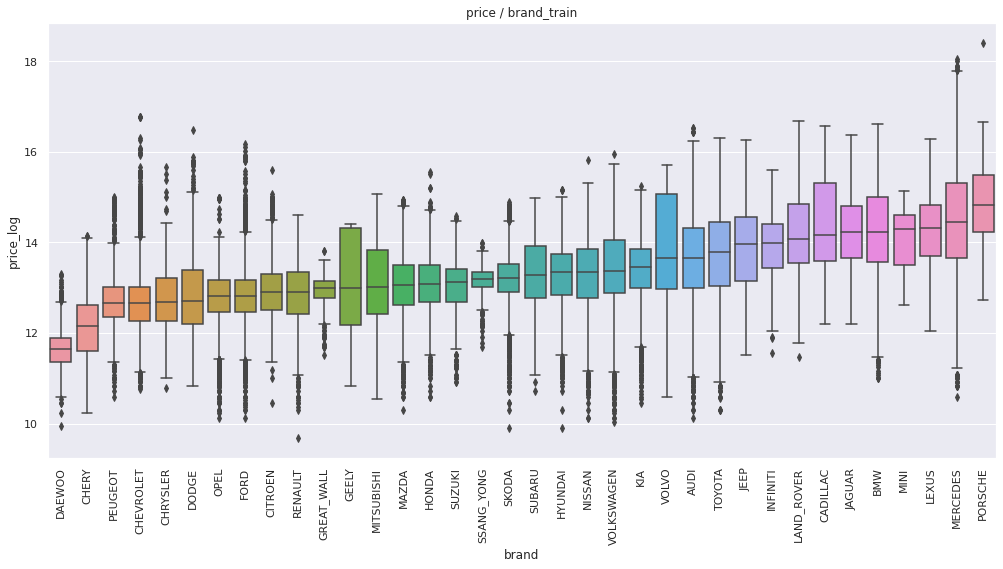

In [69]:
plt.figure(figsize=(17, 8))
order = df[df.train == 1].groupby('brand').price_log.median().sort_values().index

g = sns.boxplot(x = 'brand', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / brand_train')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

Cамыми дорогими авто в среднем оказались PORSCHE и MERCEDES, что весьма логично  учитывая статус брендов. Можно сделать вывод, что зависимость цены от бренда присутствует. Логичным решением будет сократить тренировочную часть до брендов из теста, а лишние вывести в отдельное значение *Other*, но перед этим можно создать новую фичу, на основании страны бренда и проверить зависимость. При неудовлетворительных или противоречивых результатах значения лишних стран так же поместим в *Other*

In [70]:
df.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [71]:
# Создадим признак country_of_brand, показывающий принадлежность бренда к определенной стране производителю

countries = {
    'BMW': 'Germany',
    'AUDI': 'Germany',
    'CADILLAC' : 'USA',
    'CHERY' : 'China',
    'CHEVROLET' : 'USA',
    'CHRYSLER' : 'USA',
    'CITROEN' : 'France',
    'DAEWOO' : 'Korea',
    'DODGE' : 'USA',
    'FORD': 'USA',
    'GEELY' : 'China',
    'HONDA' : 'Japan',
    'HYUNDAI': 'Korea',
    'INFINITI' : 'Japan',
    'JAGUAR' : 'UK',
    'JEEP' : 'USA',
    'KIA' : 'Korea',
    'LEXUS' : 'Japan',
    'MAZDA' : 'Japan',
    'MERCEDES': 'Germany',
    'MINI' : 'UK',
    'MITSUBISHI': 'Japan',
    'NISSAN' : 'Japan',
    'OPEL' : 'Germany',
    'PEUGEOT': 'France',
    'PORSCHE' : 'Germany',
    'RENAULT' : 'France',
    'SKODA' : 'Czech Republic',
    'SUBARU' : 'Japan',
    'SUZUKI' : 'Japan',
    'TOYOTA': 'Japan',
    'VOLKSWAGEN': 'Germany',
    'VOLVO': 'Sweden',
    'LAND_ROVER': 'UK',
    'SSANG_YONG' : 'Korea',
    'GREAT_WALL' : 'China'
}

In [72]:
df['country_of_brand'] = df['brand'].map(countries)

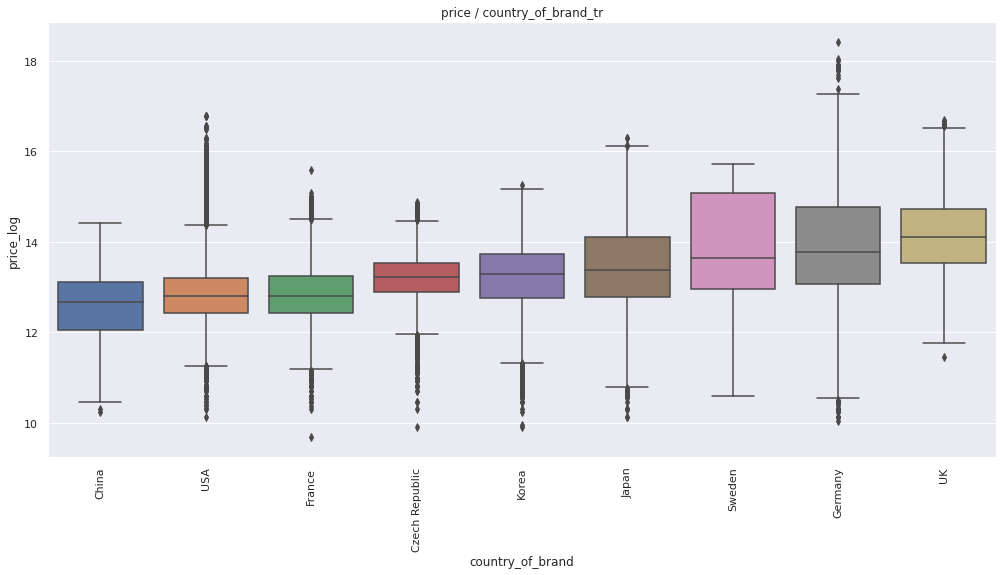

In [73]:
plt.figure(figsize=(17, 8))
order = df[df.train == 1].groupby('country_of_brand').price_log.median().sort_values().index

g = sns.boxplot(x = 'country_of_brand', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / country_of_brand_tr')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

Как и предполагалось, самыми дорогими являются британские и немецкие авто, а самыми дешевыми китайские. Очевидно, что в данном случае зависимость цены от страны бренда есть.

In [74]:
col_info(df[df.train == 1]['country_of_brand'])

Количество пропусков: 0

count       85390
unique          9
top       Germany
freq        28955
Name: country_of_brand, dtype: object

Распределение:
Germany           28955
Japan             20328
Korea             12764
USA                9852
France             5405
Czech Republic     2688
UK                 2162
Sweden             1992
China              1244
Name: country_of_brand, dtype: int64



In [75]:
col_info(df[df.train == 0]['country_of_brand'])

Количество пропусков: 0

count       34686
unique          4
top       Germany
freq        16478
Name: country_of_brand, dtype: object

Распределение:
Germany           16478
Japan             14004
Czech Republic     2741
Sweden             1463
Name: country_of_brand, dtype: int64



Идея для фичи: Возможно имеет смысл разграничить бренды на премиум и массовый сегменты до отделения лишних значенй. Информацию о принадлежности к сегментам возьмем на сайте АВТОСТАТА www.autostat.ru/news/45243/

In [76]:
premium = {
    'BMW': 1,
    'AUDI': 1,
    'CADILLAC' : 1,
    'CHERY' : 0,
    'CHEVROLET' : 0,
    'CHRYSLER' : 0,
    'CITROEN' : 0,
    'DAEWOO' : 0,
    'DODGE' : 0,
    'FORD': 0,
    'GEELY' : 0,
    'HONDA' : 0,
    'HYUNDAI': 0,
    'INFINITI' : 1,
    'JAGUAR' : 1,
    'JEEP' : 1,
    'KIA' : 0,
    'LEXUS' : 1,
    'MAZDA' : 0,
    'MERCEDES': 1,
    'MINI' : 1,
    'MITSUBISHI': 0,
    'NISSAN' : 0,
    'OPEL' : 0,
    'PEUGEOT': 0,
    'PORSCHE' : 1,
    'RENAULT' : 0,
    'SKODA' : 0,
    'SUBARU' : 0,
    'SUZUKI' : 0,
    'TOYOTA': 0,
    'VOLKSWAGEN': 0,
    'VOLVO': 1,
    'LAND_ROVER': 1,
    'SSANG_YONG' : 0,
    'GREAT_WALL' : 0
}

In [77]:
df['premium'] = df['brand'].map(premium)
df.premium.value_counts()

0    78809
1    41267
Name: premium, dtype: int64

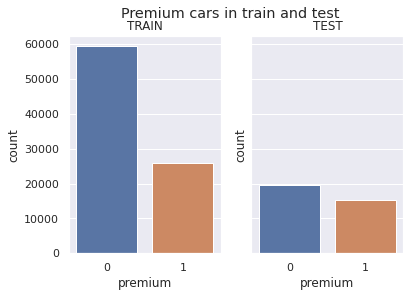

In [78]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.suptitle('Premium cars in train and test')

_ = sns.countplot(x = 'premium', data = df[df.train == 1], ax=axes[0])
axes[0].set_title('TRAIN')

_ = sns.countplot(x = 'premium', data = df[df.train == 0], ax=axes[1])
axes[1].set_title('TEST')

plt.show()

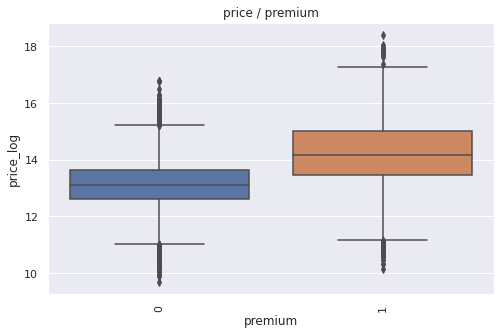

In [79]:
plt.figure(figsize=(8, 5))

g = sns.boxplot(x = 'premium', y = 'price_log', data = df[df.train == 1])
g.set_title('price / premium')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

Как видно на графике, зависимость цены от премиальности бренда присутствует. Автомобили премиум сегмента в среднем дороже автомобилей массового сегмента

Теперь определим лишние значения в признаках *brand* и *country_of_brand* тренировочной части в значение *other*

In [80]:
# Признак brand

brand_test = list(df[df.train == 0].brand.unique())
brand_test

['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

In [81]:
df['brand'] = df.brand.apply(lambda x: x if x in brand_test else 'other')

In [82]:
df['brand'].value_counts()

other         39265
MERCEDES      11791
BMW           11429
VOLKSWAGEN    11210
NISSAN         9709
TOYOTA         8476
AUDI           7212
MITSUBISHI     6042
SKODA          5429
VOLVO          3455
HONDA          2312
INFINITI       1886
LEXUS          1860
Name: brand, dtype: int64

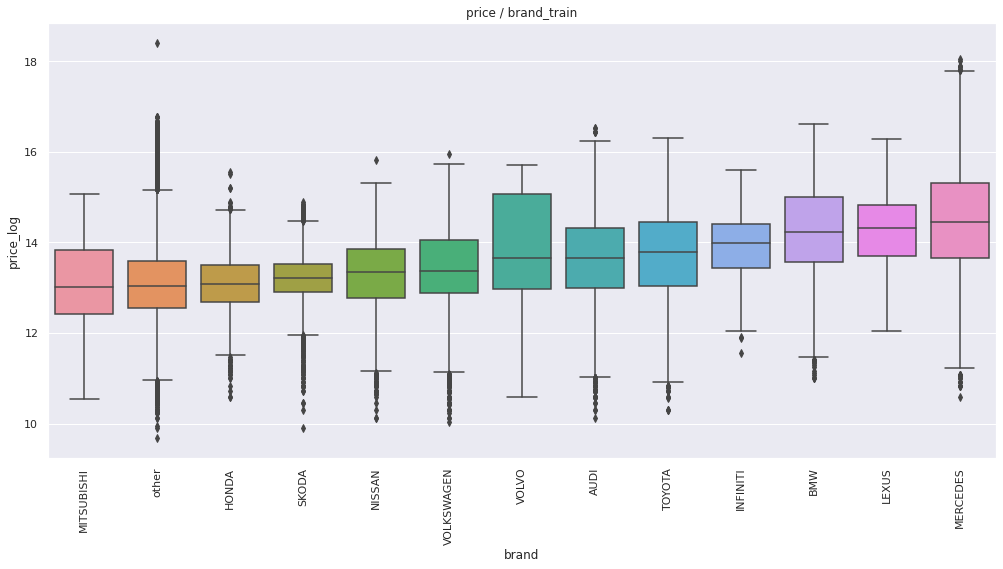

In [83]:
plt.figure(figsize=(17, 8))
order = df[df.train == 1].groupby('brand').price_log.median().sort_values().index

g = sns.boxplot(x = 'brand', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / brand_train')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

In [84]:
# Признак country_of_brand

country_test = list(df[df.train == 0].country_of_brand.unique())
country_test

['Czech Republic', 'Germany', 'Japan', 'Sweden']

In [85]:
df['country_of_brand'] = df.country_of_brand.apply(lambda x: x if x in country_test else 'other')

In [86]:
df['country_of_brand'].value_counts()

Germany           45433
Japan             34332
other             31427
Czech Republic     5429
Sweden             3455
Name: country_of_brand, dtype: int64

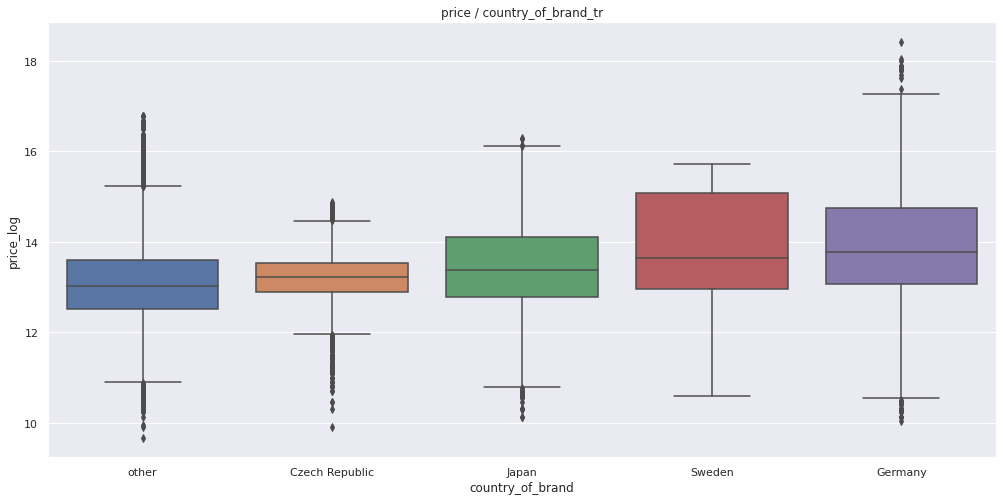

In [87]:
plt.figure(figsize=(17, 8))
order = df[df.train == 1].groupby('country_of_brand').price_log.median().sort_values().index

g = sns.boxplot(x = 'country_of_brand', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / country_of_brand_tr')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Не уверен, что это была хорошая идея, медианные цены на графике не сильно разнятся в зависимости от страны после изменения признака (хотя до него на графике очевидно зависимость присутствовала). Пока оставим данный признак. Впоследствии проверим работу модели с ним и без.

In [88]:
# Внесем данные признаки в наши списки

cat_cols.append('brand')
cat_cols.append('country_of_brand')
bin_cols.append('premium')

## 3. color

In [89]:
col_info(df.color)

Количество пропусков: 0

count     120076
unique        16
top       чёрный
freq       34939
Name: color, dtype: object

Распределение:
чёрный         34939
белый          20975
серебристый    15109
серый          14316
синий          11745
красный         5958
коричневый      4909
зелёный         3474
бежевый         2452
голубой         1815
золотистый      1031
пурпурный        992
жёлтый           886
фиолетовый       815
оранжевый        622
розовый           38
Name: color, dtype: int64



In [90]:
col_info(df[df.train == 0].color)

Количество пропусков: 0

count      34686
unique        16
top       чёрный
freq       11010
Name: color, dtype: object

Распределение:
чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64



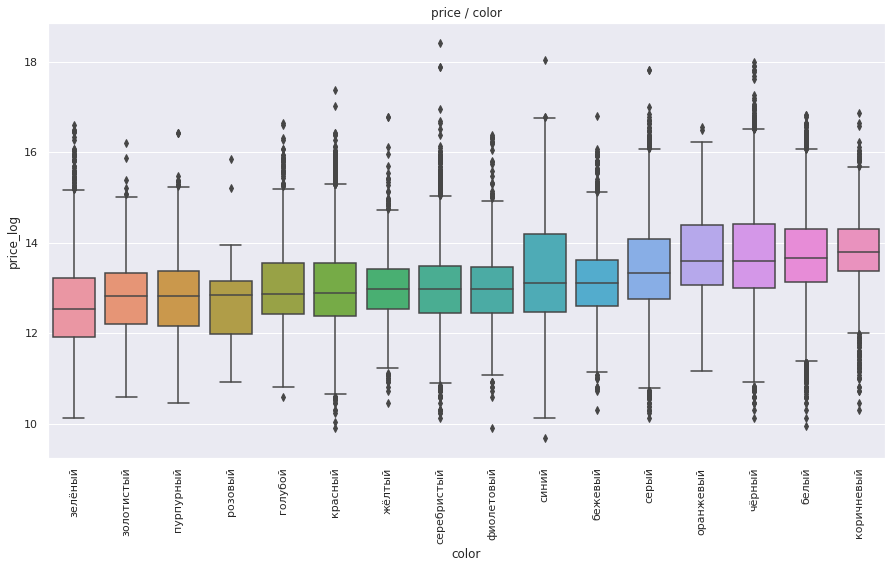

In [91]:
plt.figure(figsize=(15, 8))
order = df[df.train == 1].groupby('color').price_log.median().sort_values().index

g = sns.boxplot(x = 'color', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / color')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

plt.show()

In [92]:
# Внесем данный признак в наши списки

cat_cols.append('color')

## 4. fuelType

In [93]:
col_info(df.fuelType)

Количество пропусков: 0

count     120076
unique         5
top       бензин
freq      100417
Name: fuelType, dtype: object

Распределение:
бензин     100417
дизель      18965
гибрид        513
электро       163
газ            18
Name: fuelType, dtype: int64



In [94]:
col_info(df[df.train==0].fuelType)

Количество пропусков: 0

count      34686
unique         5
top       бензин
freq       28601
Name: fuelType, dtype: object

Распределение:
бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64



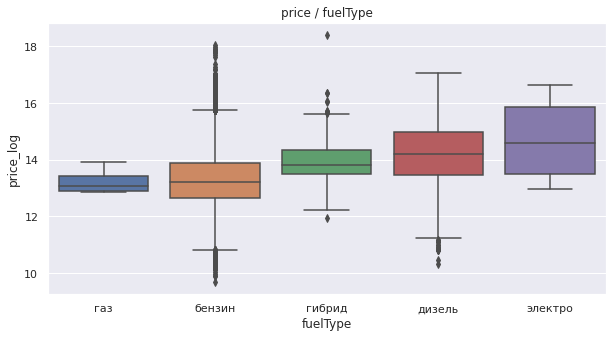

In [95]:
plt.figure(figsize=(10, 5))
order = df[df.train == 1].groupby('fuelType').price_log.median().sort_values().index

g = sns.boxplot(x = 'fuelType', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / fuelType')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

In [96]:
# Внесем данный признак в наши списки

cat_cols.append('fuelType')

## 5. modelDate

In [97]:
# train

col_info(df[df.train == 1].modelDate)

Количество пропусков: 0

count    85390.000000
mean      2008.226994
std          7.347571
min       1904.000000
25%       2005.000000
50%       2009.000000
75%       2014.000000
max       2020.000000
Name: modelDate, dtype: float64

Распределение:
2006    6075
2010    5836
2009    5638
2011    4706
2017    4685
        ... 
1948       1
1967       1
1934       1
1935       1
1969       1
Name: modelDate, Length: 78, dtype: int64



In [98]:
# test

col_info(df[df.train == 0].modelDate)

Количество пропусков: 0

count    34686.000000
mean      2007.074728
std          7.415894
min       1904.000000
25%       2004.000000
50%       2008.000000
75%       2012.000000
max       2020.000000
Name: modelDate, dtype: float64

Распределение:
2010    2503
2013    2275
2008    2243
2011    2173
2006    2169
        ... 
1960       1
1973       1
1904       1
1963       1
1965       1
Name: modelDate, Length: 66, dtype: int64



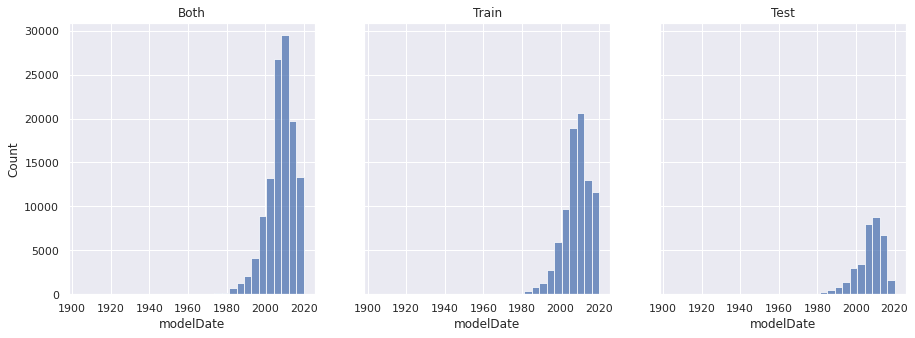

In [99]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.modelDate, ax=ax[0], bins=30)
_ = sns.histplot(df[df.train == 1].modelDate, ax=ax[1], bins=30)
_ = sns.histplot(df[df.train == 0].modelDate, ax=ax[2], bins=30)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

Распределение данных в трейне и тесте примерно одинаковое

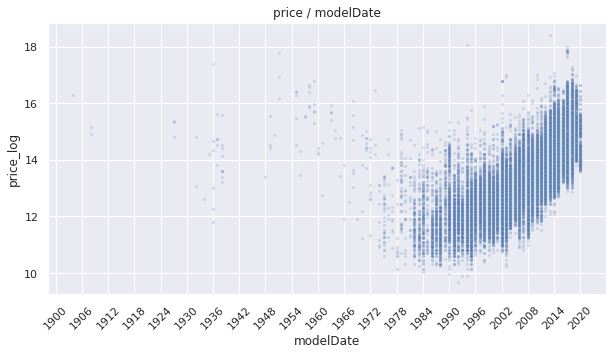

In [100]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'modelDate', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=10)
g.set_title('price / modelDate')
g.set_ylabel('price_log')
g.set_xticks(np.linspace(1900, 2020, 21))
plt.xticks(rotation=45)
plt.show()

Как видим, начиная приблизительно с 1980 года зависимость линейная (чем новее модель авто, тем оно дороже). Значения ниже 1980 с высоким ценником скорее всего автораритеты. Проверим

In [101]:
df[(df.train == 1) & (df.modelDate < 1980) & (df.price_log > 12)]

bodyType     brand  ... country_of_brand premium
63     универсал 5 дв.      AUDI  ...          Germany       1
300              седан      AUDI  ...          Germany       1
3791       седан 2 дв.       BMW  ...          Germany       1
4460       седан 2 дв.       BMW  ...          Germany       1
5447       седан 2 дв.       BMW  ...          Germany       1
...                ...       ...  ...              ...     ...
84675            седан  MERCEDES  ...          Germany       1
84676            седан  MERCEDES  ...          Germany       1
84677             купе  MERCEDES  ...          Germany       1
84678             купе  MERCEDES  ...          Germany       1
84679            седан  MERCEDES  ...          Germany       1

[166 rows x 29 columns]

И правда, по описанию некоторых экземпляров можно понять, что эти авто - раритеты

In [102]:
df[(df.train == 0) & (df.modelDate < 1980)]

bodyType     brand  ... country_of_brand premium
85926           седан     SKODA  ...   Czech Republic       0
86161           седан     SKODA  ...   Czech Republic       0
87167   хэтчбек 3 дв.     SKODA  ...   Czech Republic       0
87184           седан     SKODA  ...   Czech Republic       0
88564           седан      AUDI  ...          Germany       1
...               ...       ...  ...              ...     ...
117158          седан  MERCEDES  ...          Germany       1
119138    седан 2 дв.       BMW  ...          Germany       1
119266          седан      AUDI  ...          Germany       1
119583          седан  MERCEDES  ...          Germany       1
119630          седан  MERCEDES  ...          Germany       1

[116 rows x 29 columns]

К сожалению, пока что я не понимаю по каким критериям отделить раритеты (Возможно я мог бы в трейне создать признак на основании года модели (меньше 1980), цены, а так же слов встречающихся в признаке description а после этого обучить модель и предсказать значение данного признака в test)

In [103]:
# Внесем данный признак в наши списки

num_cols.append('modelDate')

## 6. productionDate

In [104]:
# train

col_info(df[df.train == 1].productionDate)

Количество пропусков: 0

count    85390.00000
mean      2010.51670
std          6.94217
min       1904.00000
25%       2007.00000
50%       2011.00000
75%       2015.00000
max       2020.00000
Name: productionDate, dtype: float64

Распределение:
2020    9788
2008    6965
2012    6553
2011    6113
2013    5533
        ... 
1960       1
1955       1
1954       1
1948       1
1949       1
Name: productionDate, Length: 80, dtype: int64



In [105]:
# test

col_info(df[df.train == 0].productionDate)

Количество пропусков: 0

count    34686.000000
mean      2009.264602
std          7.047661
min       1904.000000
25%       2006.000000
50%       2011.000000
75%       2014.000000
max       2020.000000
Name: productionDate, dtype: float64

Распределение:
2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1936       1
1904       1
1967       1
1960       1
1952       1
Name: productionDate, Length: 69, dtype: int64



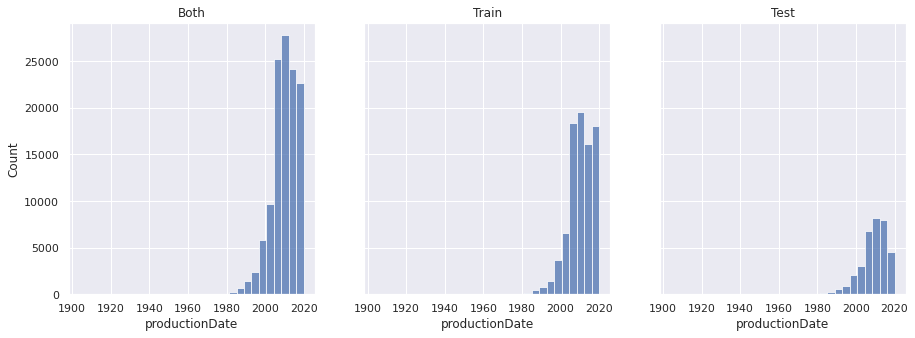

In [106]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.productionDate, ax=ax[0], bins=30)
_ = sns.histplot(df[df.train == 1].productionDate, ax=ax[1], bins=30)
_ = sns.histplot(df[df.train == 0].productionDate, ax=ax[2], bins=30)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

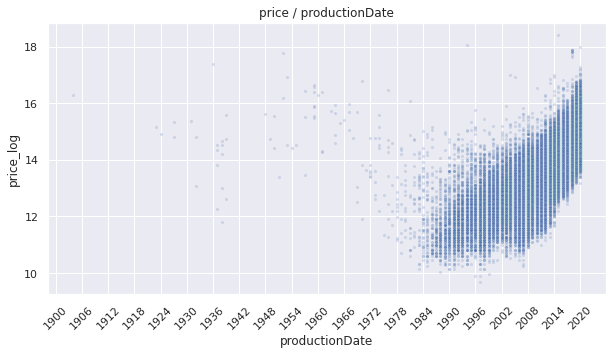

In [107]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'productionDate', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=10)
g.set_title('price / productionDate')
g.set_ylabel('price_log')
g.set_xticks(np.linspace(1900, 2020, 21))
plt.xticks(rotation=45)
plt.show()

В данном случае линейная зависимость приблизительно с 1985 еще сильнее по сравнению с modelDate, за исключением некоторых старых, предположительно отреставрированных раритетных авто. Чем позже год производства, тем дороже авто.

Создадим признак отвечающий за вовраст автомобиля (2020 год так же учитываем за целый)

In [108]:
df['car_age'] = (NOWDAYS - df.productionDate) + 1

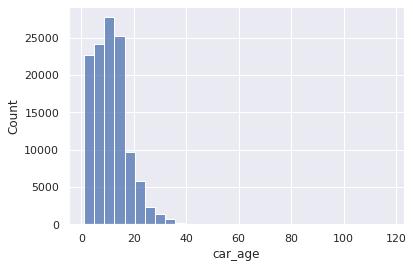

In [109]:
_ = sns.histplot(df.car_age, bins=30)

plt.show()

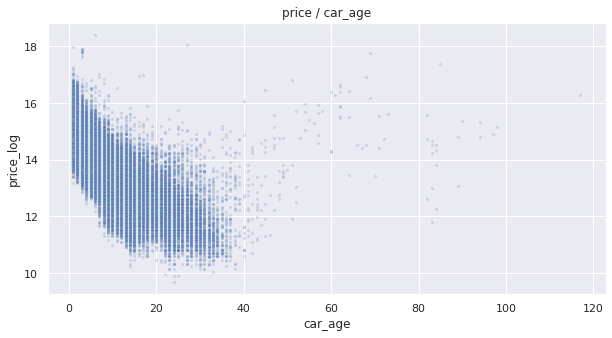

In [110]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'car_age', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=10)
g.set_title('price / car_age')
g.set_ylabel('price_log')
plt.show()

Чем старше авто, тем, как правило, ниже цена

Создадим также признак в виде разницы между датой выпуска модели и датой выпуска непосредственно авто

In [111]:
df['model_prod_date_delta'] = df.productionDate - df.modelDate

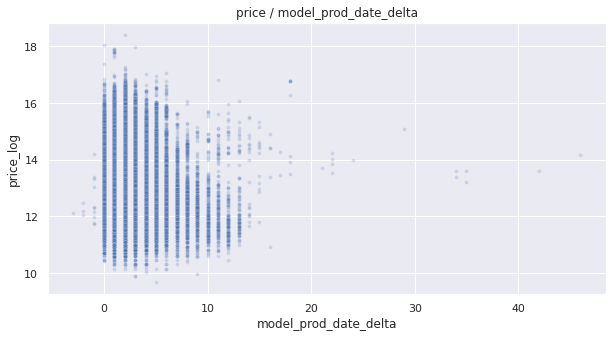

In [112]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'model_prod_date_delta', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=15)
g.set_title('price / model_prod_date_delta')
g.set_ylabel('price_log')
plt.show()

По графику видно, что чем больше разброс между датой выпуска и производства, тем меньше в среднем стоимость авто

In [113]:
# Внесем данные признаки в наши списки

num_cols.append('productionDate')
num_cols.append('car_age')
num_cols.append('model_prod_date_delta')

## 7. numberOfDoors

In [114]:
# train

col_info(df[df.train == 1].numberOfDoors)

Количество пропусков: 0

count    85390.000000
mean         4.501159
std          0.657778
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: numberOfDoors, dtype: float64

Распределение:
5    48718
4    32620
3     2182
2     1869
0        1
Name: numberOfDoors, dtype: int64



In [115]:
# test

col_info(df[df.train == 0].numberOfDoors)

Количество пропусков: 0

count    34686.000000
mean         4.450816
std          0.703040
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: numberOfDoors, dtype: float64

Распределение:
5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64



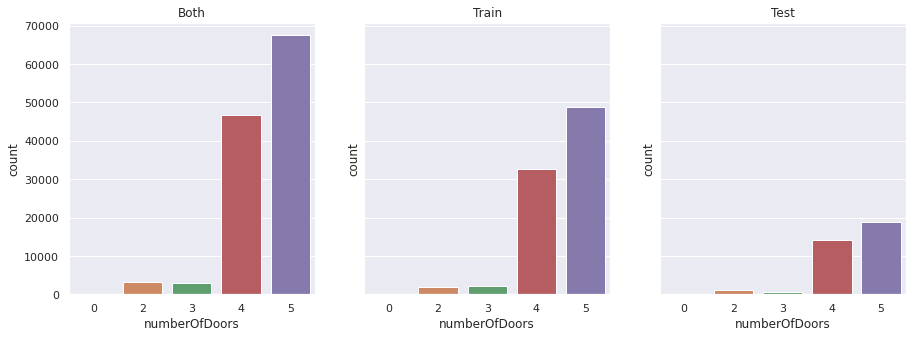

In [116]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.countplot(df.numberOfDoors, ax=ax[0])
_ = sns.countplot(df[df.train == 1].numberOfDoors, ax=ax[1])
_ = sns.countplot(df[df.train == 0].numberOfDoors, ax=ax[2])

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

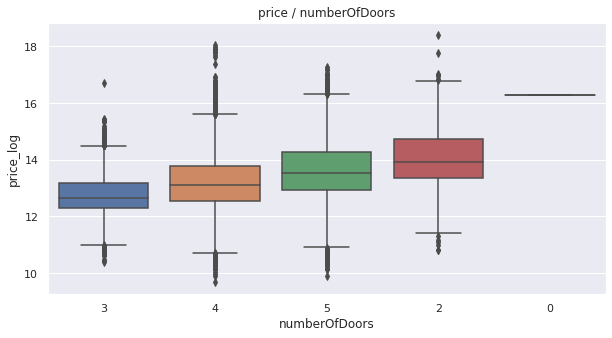

In [117]:
plt.figure(figsize=(10, 5))
order = df[df.train == 1].groupby('numberOfDoors').price_log.median().sort_values().index

g = sns.boxplot(x = 'numberOfDoors', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / numberOfDoors')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Как видно из графика, трех-четырехдверные авто чаще всего самые дешевые. Самыми же дорогими являются двухдверные авто, куда предположительно входят спорткары, и одно авто без двери. Проверим что это такое

In [118]:
df[(df.train == 1) & (df.numberOfDoors == 0)]

bodyType     brand  color  ... premium  car_age model_prod_date_delta
84103  кабриолет  MERCEDES  белый  ...       1      117                     0

[1 rows x 31 columns]

Раритеное и довольно дорогое авто, оставим его, так как в тесте так же есть значение с таким же количеством дверей

In [119]:
# Внесем данный признак в наши списки

num_cols.append('numberOfDoors')

## 8. name

In [120]:
# train

col_info(df[df.train == 1].name)

Количество пропусков: 0

count                 85390
unique                 4484
top       2.0 AT (150 л.с.)
freq                   1547
Name: name, dtype: object

Распределение:
2.0 AT (150 л.с.)             1547
1.6 AT (123 л.с.)             1262
1.6 AT (110 л.с.)             1016
1.6 MT (105 л.с.)              884
1.4 MT (75 л.с.)               775
                              ... 
2.3 MT (350 л.с.) 4WD            1
3.0d MT (163 л.с.) 4WD           1
2.2d AT (200 л.с.)               1
GT 2.0 AT (156 л.с.)             1
Hard Top 2.0 MT (160 л.с.)       1
Name: name, Length: 4484, dtype: int64



In [121]:
# test

col_info(df[df.train == 0].name)

Количество пропусков: 0

count                 34686
unique                 2780
top       1.6 AT (110 л.с.)
freq                    631
Name: name, dtype: object

Распределение:
1.6 AT (110 л.с.)                  631
1.6 MT (102 л.с.)                  410
1.6 MT (110 л.с.)                  314
2.0 CVT (141 л.с.) 4WD             309
1.4 AMT (122 л.с.)                 308
                                  ... 
30d 3.0d MT (218 л.с.) 4WD           1
350 Long 3.0d AT (258 л.с.) 4WD      1
230 1.8 MT (192 л.с.)                1
1.5 CVT (120 л.с.)                   1
1.6 AT (102 л.с.) 4WD                1
Name: name, Length: 2780, dtype: int64



Данный признак является лишь компиляцией других и включает в себя тип коробки передач, количество л.с., объем двигателя, тип привода. Удалим данный признак из нашего датасета.

In [122]:
df.drop(columns='name', inplace=True)

## 9. vehicleConfiguration

In [123]:
# train

col_info(df[df.train == 1].vehicleConfiguration)

Количество пропусков: 0

count                    85390
unique                    1860
top       SEDAN MECHANICAL 1.6
freq                      4109
Name: vehicleConfiguration, dtype: object

Распределение:
SEDAN MECHANICAL 1.6                 4109
SEDAN AUTOMATIC 1.6                  3457
ALLROAD_5_DOORS AUTOMATIC 2.0        2716
ALLROAD_5_DOORS VARIATOR 2.0         2167
SEDAN AUTOMATIC 2.0                  2152
                                     ... 
SEDAN VARIATOR 2.5d                     1
HATCHBACK_5_DOORS ROBOT 1.5d            1
HATCHBACK_5_DOORS MECHANICAL 1.7d       1
HATCHBACK_5_DOORS AUTOMATIC 130i        1
SEDAN AUTOMATIC N46                     1
Name: vehicleConfiguration, Length: 1860, dtype: int64



То же, что и признак name - удаляем

In [124]:
df.drop(columns='vehicleConfiguration', inplace=True)

## 10. vehicleTransmission

In [125]:
# train

col_info(df[df.train == 1].vehicleTransmission)

Количество пропусков: 0

count              85390
unique                 4
top       автоматическая
freq               47243
Name: vehicleTransmission, dtype: object

Распределение:
автоматическая      47243
механическая        24898
роботизированная     7348
вариатор             5901
Name: vehicleTransmission, dtype: int64



In [126]:
# test

col_info(df[df.train == 0].vehicleTransmission)

Количество пропусков: 0

count              34686
unique                 4
top       автоматическая
freq               19596
Name: vehicleTransmission, dtype: object

Распределение:
автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64



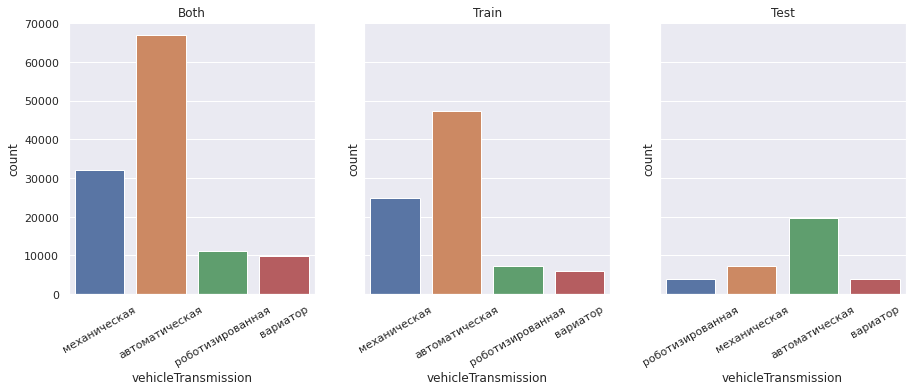

In [127]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.countplot(df.vehicleTransmission, ax=ax[0])
_ = sns.countplot(df[df.train == 1].vehicleTransmission, ax=ax[1])
_ = sns.countplot(df[df.train == 0].vehicleTransmission, ax=ax[2])

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30)

plt.show()

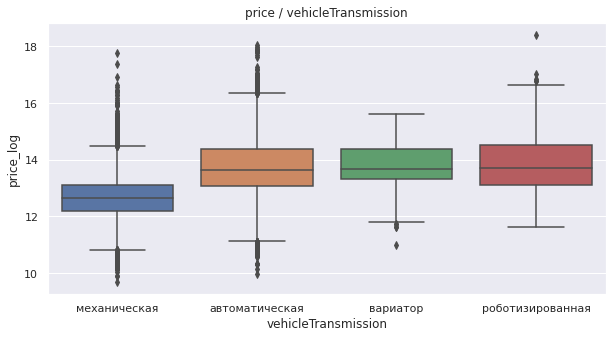

In [128]:
plt.figure(figsize=(10, 5))
order = df[df.train == 1].groupby('vehicleTransmission').price_log.median().sort_values().index

g = sns.boxplot(x = 'vehicleTransmission', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / vehicleTransmission')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

In [129]:
# Внесем данный признак в наши списки

cat_cols.append('vehicleTransmission')

## 11. enginePower

In [130]:
# train

col_info(df[df.train == 1].enginePower)

Количество пропусков: 0

count       85390
unique        396
top       150 N12
freq         6660
Name: enginePower, dtype: object

Распределение:
150 N12    6660
249 N12    3375
140 N12    2830
105 N12    2338
123 N12    2150
           ... 
236 N12       1
466 N12       1
403 N12       1
232 N12       1
761 N12       1
Name: enginePower, Length: 396, dtype: int64



In [131]:
# test

col_info(df[df.train == 0].enginePower)

Количество пропусков: 0

count       34686
unique        315
top       249 N12
freq         1708
Name: enginePower, dtype: object

Распределение:
249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
61 N12        1
514 N12       1
383 N12       1
254 N12       1
42 N12        1
Name: enginePower, Length: 315, dtype: int64



In [132]:
# Приведем данный признак к числовому значению

df['enginePower'] = df.enginePower.apply(lambda x: int(x.split(' ')[0]))

In [133]:
col_info(df[df.train == 1].enginePower)

Количество пропусков: 0

count    85390.000000
mean       170.954421
std         84.086503
min         11.000000
25%        115.000000
50%        150.000000
75%        199.000000
max        800.000000
Name: enginePower, dtype: float64

Распределение:
150    6660
249    3375
140    2830
105    2338
123    2150
       ... 
475       1
359       1
570       1
410       1
402       1
Name: enginePower, Length: 396, dtype: int64



In [134]:
col_info(df[df.train == 0].enginePower)

Количество пропусков: 0

count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64

Распределение:
249    1708
150    1699
110    1039
170     977
105     955
       ... 
38        1
485       1
324       1
164       1
32        1
Name: enginePower, Length: 315, dtype: int64



Оставим значения мощности в пределах минимума и максимума значений тестовой части

In [135]:
test_power_max = df[df.train == 0].enginePower.max()
test_power_min = df[df.train == 0].enginePower.min()

print(test_power_max)
print(test_power_min)

639
30


In [136]:
df = df[(df.enginePower <= test_power_max) & (df.enginePower >= test_power_min)]

In [137]:
col_info(df.enginePower)

Количество пропусков: 0

count    120062.000000
mean        175.895071
std          85.776686
min          30.000000
25%         116.000000
50%         150.000000
75%         210.000000
max         639.000000
Name: enginePower, dtype: float64

Распределение:
150    8359
249    5083
140    3772
105    3293
110    2926
       ... 
410       1
526       1
403       1
466       1
412       1
Name: enginePower, Length: 388, dtype: int64



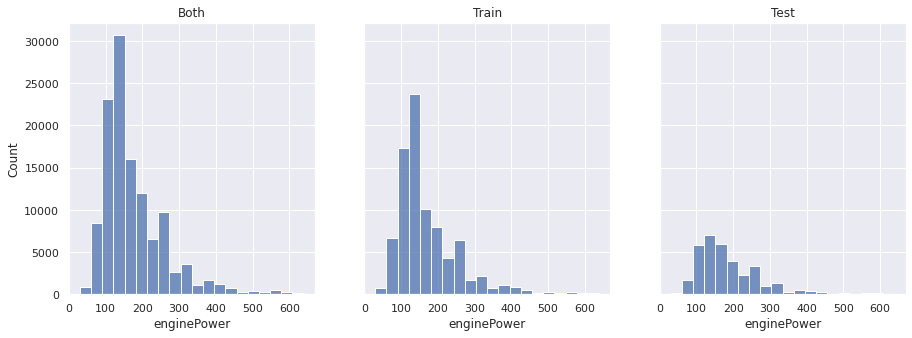

In [138]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.enginePower, ax=ax[0], bins=20)
_ = sns.histplot(df[df.train == 1].enginePower, ax=ax[1], bins=20)
_ = sns.histplot(df[df.train == 0].enginePower, ax=ax[2], bins=20)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

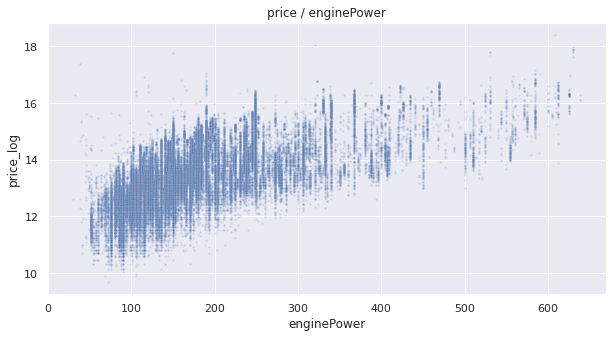

In [139]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'enginePower', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=5)
g.set_title('price / enginePower')
g.set_ylabel('price_log')
plt.show()

In [140]:
df.enginePower.value_counts(bins=3)

(29.389999999999997, 233.0]    95090
(233.0, 436.0]                 22872
(436.0, 639.0]                  2100
Name: enginePower, dtype: int64

На гистограмме видим скорее всего логнормальное распределение. Создадим новый признак enginePower_log

In [141]:
df['enginePower_log'] = np.log(df.enginePower)

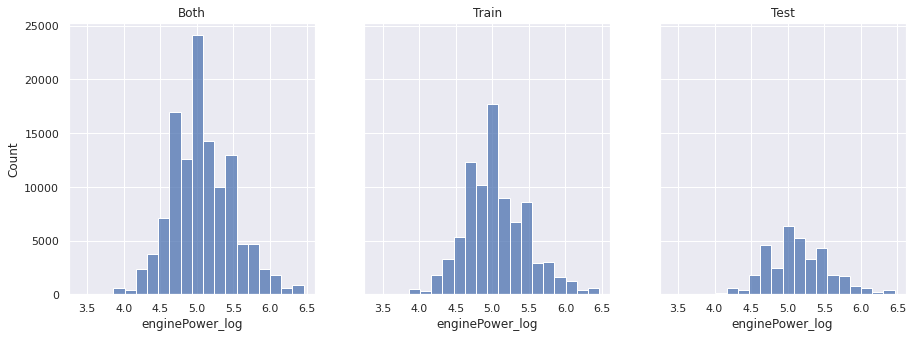

In [142]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.enginePower_log, ax=ax[0], bins=20)
_ = sns.histplot(df[df.train == 1].enginePower_log, ax=ax[1], bins=20)
_ = sns.histplot(df[df.train == 0].enginePower_log, ax=ax[2], bins=20)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

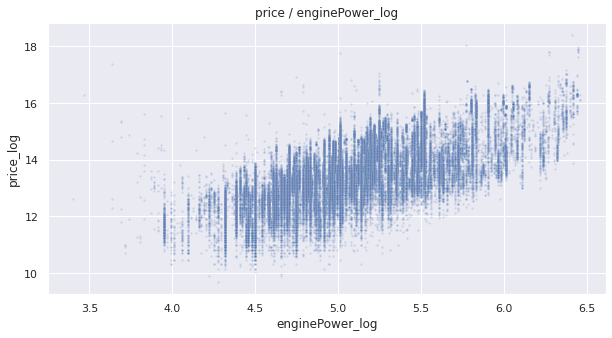

In [143]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'enginePower_log', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=5)
g.set_title('price / enginePower_log')
g.set_ylabel('price_log')
plt.show()

Итого по признаку:
1. Большинство значений варьируется в пределах от 50 до 250.
2. Признак имеет линейную зависимость (чем больше значение, тем больше цена авто)

In [144]:
# Внесем данные признаки в наши списки
num_cols.append('enginePower')
num_cols.append('enginePower_log')

## 12. engineDisplacement

Перед работой над признаком переведем значения из л в см3

In [145]:
# Переведем тип признака в float

df['engineDisplacement'] = df.engineDisplacement.astype('float') * 1000
df['engineDisplacement'] 

0         2800.0
1         1800.0
2         2300.0
3         1800.0
4         2000.0
           ...  
120071    1600.0
120072    2000.0
120073    2500.0
120074    2000.0
120075    3000.0
Name: engineDisplacement, Length: 120062, dtype: float64

In [146]:
# train

col_info(df[df.train == 1].engineDisplacement)

Количество пропусков: 102

count    85274.000000
mean      2209.838872
std        888.143359
min          0.000000
25%       1600.000000
50%       2000.000000
75%       2500.000000
max       8400.000000
Name: engineDisplacement, dtype: float64

Распределение:
2000.0    19536
1600.0    18316
3000.0     6402
1800.0     5965
1400.0     5625
          ...  
6500.0        1
8200.0        1
8100.0        1
8400.0        1
7400.0        1
Name: engineDisplacement, Length: 68, dtype: int64



In [147]:
# test

col_info(df[df.train == 0].engineDisplacement)

Количество пропусков: 55

count    34631.000000
mean      2406.069706
std        960.482603
min        700.000000
25%       1800.000000
50%       2000.000000
75%       3000.000000
max       6600.000000
Name: engineDisplacement, dtype: float64

Распределение:
2000.0    7391
1600.0    4973
3000.0    3915
1800.0    3349
2500.0    2477
2400.0    1745
3500.0    1710
1400.0    1635
1500.0     725
1200.0     485
4400.0     447
2800.0     384
4700.0     377
1300.0     365
5500.0     361
4000.0     356
3200.0     348
4500.0     346
2100.0     271
3700.0     242
2200.0     236
4200.0     228
1900.0     221
2300.0     203
2700.0     189
3600.0     183
5600.0     170
5000.0     158
5700.0     135
2900.0     131
4600.0     108
3100.0      88
4800.0      84
1700.0      59
3800.0      57
1000.0      57
2600.0      55
6000.0      53
700.0       53
3300.0      44
3400.0      36
4100.0      35
4300.0      32
5400.0      31
6200.0      28
5200.0      12
5900.0      12
6300.0       8
5800.0       7
6600.0

Количество в пропусках train и test подозрительно знакомы, скорее всего это электрокары, где литраж двигателя указан не был

In [148]:
df[(df.train == 1) & (df.fuelType == 'электро')].engineDisplacement

2724     NaN
2725     NaN
2726     NaN
2727     NaN
2728     NaN
        ... 
54589    NaN
66944    NaN
77312    NaN
79949    0.0
79950    0.0
Name: engineDisplacement, Length: 104, dtype: float64

In [149]:
df[(df.train == 0) & (df.fuelType == 'электро')].engineDisplacement

90631    NaN
93382    NaN
93642    NaN
93740    NaN
94074    NaN
94112    NaN
94307    NaN
96207    NaN
96326    NaN
96433    NaN
96692    NaN
97072    NaN
97104    NaN
97109    NaN
97144    NaN
97268    NaN
97364    NaN
97462    NaN
97475    NaN
97490    NaN
97640    NaN
97677    NaN
97724    NaN
97856    NaN
97871    NaN
97948    NaN
97972    NaN
98068    NaN
98139    NaN
98244    NaN
98306    NaN
98338    NaN
98340    NaN
98442    NaN
98494    NaN
98495    NaN
98868    NaN
99023    NaN
99050    NaN
99110    NaN
99202    NaN
99305    NaN
99342    NaN
99379    NaN
99537    NaN
99809    NaN
109259   NaN
109338   NaN
112454   NaN
113631   NaN
118058   NaN
118090   NaN
118188   NaN
119549   NaN
119894   NaN
Name: engineDisplacement, dtype: float64

In [150]:
df[(df.fuelType == 'электро')]

bodyType     brand  ... model_prod_date_delta enginePower_log
2724    внедорожник 5 дв.      AUDI  ...                     2        6.011267
2725    внедорожник 5 дв.      AUDI  ...                     2        6.011267
2726    внедорожник 5 дв.      AUDI  ...                     2        6.011267
2727    внедорожник 5 дв.      AUDI  ...                     2        6.011267
2728    внедорожник 5 дв.      AUDI  ...                     2        6.011267
...                   ...       ...  ...                   ...             ...
118058      хэтчбек 5 дв.    NISSAN  ...                     1        5.010635
118090      хэтчбек 5 дв.    NISSAN  ...                     1        4.691348
118188      хэтчбек 5 дв.    NISSAN  ...                     3        4.691348
119549      хэтчбек 5 дв.  MERCEDES  ...                     2        5.187386
119894      хэтчбек 5 дв.    NISSAN  ...                     3        4.691348

[159 rows x 30 columns]

Выявим наиболее часто встречающиеся параметры и интервалы в значениях и по ним найдем авто схожие с электрокарами по параметрам. На основе их объема двигателя заполним столбец. (Фильтровать будем по тесту)

**признак bodyType**

In [151]:
print(df[(df.fuelType == 'электро')].bodyType_1.value_counts())
print()
print(df[(df.fuelType == 'электро')].bodyType_2.value_counts())

хэтчбек        109
внедорожник     47
седан            3
Name: bodyType_1, dtype: int64

хэтчбек 5 дв.        109
внедорожник 5 дв.     47
седан                  3
Name: bodyType_2, dtype: int64


In [152]:
print(df[(df.train==0) & (df.fuelType == 'электро')].bodyType_1.value_counts())
print()
print(df[(df.train==0) & (df.fuelType == 'электро')].bodyType_2.value_counts())

хэтчбек        54
внедорожник     1
Name: bodyType_1, dtype: int64

хэтчбек 5 дв.        54
внедорожник 5 дв.     1
Name: bodyType_2, dtype: int64


Наиболее встречающиеся значения тут это хэтчбек и внедорожник, фильтровать будем про признаку bodyType_1 ибо числа не различаются. Попробуем для начала отфильтровать по значению хэтчбек

**признак brand**

In [153]:
df[(df.fuelType == 'электро')].brand.value_counts()

NISSAN        82
AUDI          40
BMW           16
other         10
MITSUBISHI     4
MERCEDES       4
VOLKSWAGEN     3
Name: brand, dtype: int64

In [154]:
df[(df.train==0) & (df.fuelType == 'электро')].brand.value_counts()

NISSAN        40
BMW            9
VOLKSWAGEN     2
MITSUBISHI     2
MERCEDES       1
AUDI           1
Name: brand, dtype: int64

In [155]:
pd.pivot_table(data=df[(df.train==1) & (df.fuelType == 'электро')], values='price', columns='brand', aggfunc='mean')

brand          AUDI           BMW  ...  VOLKSWAGEN      other
price  7.630065e+06  2.017469e+06  ...   1850000.0  7366217.6

[1 rows x 7 columns]

Для начала отфильтруем по трем брендам (NISSAN, BMW и AUDI)

**признак numberOfDoors**

In [156]:
df[(df.fuelType == 'электро')].numberOfDoors.value_counts()

5    156
4      3
Name: numberOfDoors, dtype: int64

Возьмем значение 5

**признак enginePower**

In [157]:
df[(df.fuelType == 'электро')].enginePower.value_counts()

109    78
408    42
170    16
234     5
150     4
67      4
115     3
530     3
179     2
145     1
143     1
Name: enginePower, dtype: int64

In [158]:
df[(df.train==0) & (df.fuelType == 'электро')].enginePower.value_counts()

109    37
170     9
150     3
115     2
67      2
408     1
179     1
Name: enginePower, dtype: int64

Значения 109, 170 и 408

**признак modelDate**

In [159]:
df[(df.fuelType == 'электро')].modelDate.value_counts(bins=2)

(2008.989, 2014.0]    101
(2014.0, 2019.0]       58
Name: modelDate, dtype: int64

In [160]:
df[(df.train==0) & (df.fuelType == 'электро')].modelDate.value_counts(bins=2)

(2009.991, 2014.0]    49
(2014.0, 2018.0]       6
Name: modelDate, dtype: int64

Возьмем значения с 2009 по 2014 год

In [161]:
# Фильтруем

df[(df.bodyType_1 == 'хэтчбек') & ((df.brand == 'AUDI') | (df.brand == 'BMW') | (df.brand == 'NISSAN')) \
   & (df.modelDate >= 2009) & (df.modelDate <= 2014) & (df.numberOfDoors == 5) & ((df.enginePower == 109) \
   | (df.enginePower == 170) | (df.enginePower == 408)) & (df.fuelType != 'электро')].engineDisplacement.value_counts()

1600.0    17
700.0     13
Name: engineDisplacement, dtype: int64

In [162]:
# На всякий случай проверим тестовую часть

df[(df.train == 0) & (df.bodyType_1 == 'хэтчбек') & ((df.brand == 'AUDI') | (df.brand == 'BMW') | (df.brand == 'NISSAN')) \
   & (df.modelDate >= 2009) & (df.modelDate <= 2014) & (df.numberOfDoors == 5) & ((df.enginePower == 109) \
   | (df.enginePower == 170) | (df.enginePower == 408)) & (df.fuelType != 'электро')].engineDisplacement.value_counts()

1600.0    9
700.0     7
Name: engineDisplacement, dtype: int64

In [163]:
# Подставим полученное значение заместо пропусков и нулей

df.engineDisplacement.fillna(1600, inplace=True)
df['engineDisplacement'] = df.engineDisplacement.apply(lambda x: 1600 if x == 0 else x)

In [164]:
# train

col_info(df[df.train == 1].engineDisplacement)

Количество пропусков: 0

count    85376.000000
mean      2209.147770
std        887.803123
min        700.000000
25%       1600.000000
50%       2000.000000
75%       2500.000000
max       8400.000000
Name: engineDisplacement, dtype: float64

Распределение:
2000.0    19536
1600.0    18420
3000.0     6402
1800.0     5965
1400.0     5625
          ...  
7500.0        1
6500.0        1
8100.0        1
7400.0        1
7300.0        1
Name: engineDisplacement, Length: 67, dtype: int64



In [165]:
# test

col_info(df[df.train == 0].engineDisplacement)

Количество пропусков: 0

count    34686.000000
mean      2404.791559
std        960.256555
min        700.000000
25%       1800.000000
50%       2000.000000
75%       3000.000000
max       6600.000000
Name: engineDisplacement, dtype: float64

Распределение:
2000.0    7391
1600.0    5028
3000.0    3915
1800.0    3349
2500.0    2477
2400.0    1745
3500.0    1710
1400.0    1635
1500.0     725
1200.0     485
4400.0     447
2800.0     384
4700.0     377
1300.0     365
5500.0     361
4000.0     356
3200.0     348
4500.0     346
2100.0     271
3700.0     242
2200.0     236
4200.0     228
1900.0     221
2300.0     203
2700.0     189
3600.0     183
5600.0     170
5000.0     158
5700.0     135
2900.0     131
4600.0     108
3100.0      88
4800.0      84
1700.0      59
3800.0      57
1000.0      57
2600.0      55
6000.0      53
700.0       53
3300.0      44
3400.0      36
4100.0      35
4300.0      32
5400.0      31
6200.0      28
5200.0      12
5900.0      12
6300.0       8
5800.0       7
6600.0 

Посмотрим что за авто, мощность которых выше максимальной в тесте

In [166]:
test_displ_max = df[df.train == 0].engineDisplacement.max()
test_displ_max

6600.0

In [167]:
df[df.engineDisplacement > 6600]

bodyType  ... enginePower_log
10801                      кабриолет  ...        5.384495
10949                          седан  ...        5.746203
11632           пикап двойная кабина  ...        5.783825
12329                           купе  ...        6.240276
13105                   купе-хардтоп  ...        5.843544
14998              внедорожник 5 дв.  ...        5.669881
15000              внедорожник 5 дв.  ...        5.451038
15308                          седан  ...        5.828946
18020  пикап двойная кабина crew cab  ...        5.857933
18086                        родстер  ...        6.396930
18202                        минивэн  ...        5.370638
18349              внедорожник 5 дв.  ...        5.749393
18350              внедорожник 5 дв.  ...        5.749393
18351              внедорожник 5 дв.  ...        5.749393
18352              внедорожник 5 дв.  ...        5.749393
18353              внедорожник 5 дв.  ...        5.749393
22775                           купе  ...        5.843544

[17 rows x 30 columns]

Удалим данные авто из нашего датасета

In [168]:
df = df[df.engineDisplacement <= test_displ_max]

In [169]:
# Проверим

df.engineDisplacement.describe()

count    120045.000000
mean       2264.973135
std         911.804155
min         700.000000
25%        1600.000000
50%        2000.000000
75%        2500.000000
max        6600.000000
Name: engineDisplacement, dtype: float64

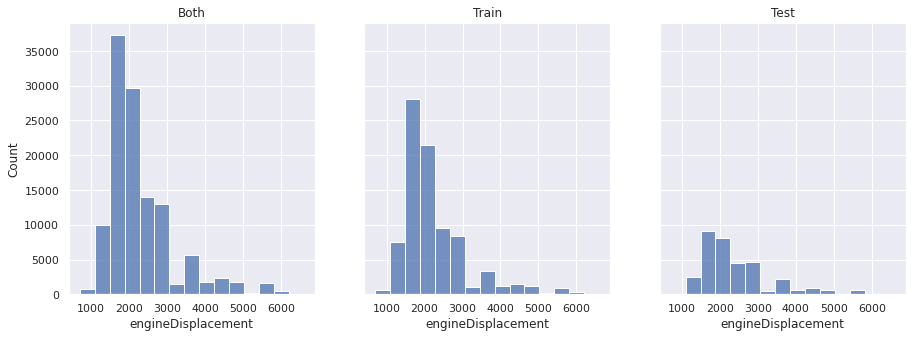

In [170]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.engineDisplacement, ax=ax[0], bins=15)
_ = sns.histplot(df[df.train == 1].engineDisplacement, ax=ax[1], bins=15)
_ = sns.histplot(df[df.train == 0].engineDisplacement, ax=ax[2], bins=15)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

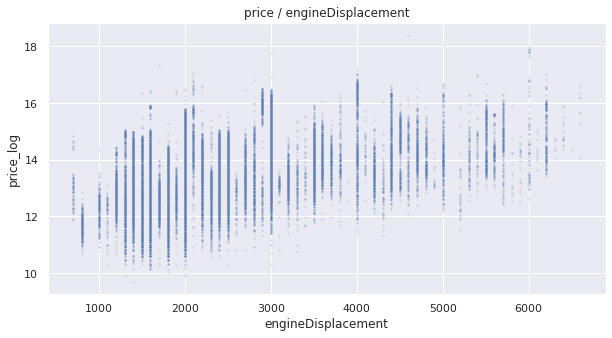

In [171]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'engineDisplacement', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=5)
g.set_title('price / engineDisplacement')
g.set_ylabel('price_log')
plt.show()

На графике видна небольшая зависимость цены от объема двигателя. Чем больше объем, тем дороже авто в среднем 

In [172]:
# Внесем данные признаки в наши списки
num_cols.append('engineDisplacement')

## 13. mileage

In [173]:
col_info(df.mileage)

Количество пропусков: 0

count     120045.000000
mean      146074.976076
std       101877.648769
min            0.000000
25%        75767.000000
50%       138600.000000
75%       200000.000000
max      1000000.000000
Name: mileage, dtype: float64

Распределение:
0         10530
200000     1567
150000     1413
180000     1236
160000     1197
          ...  
82122         1
374997        1
103941        1
131298        1
6141          1
Name: mileage, Length: 24303, dtype: int64



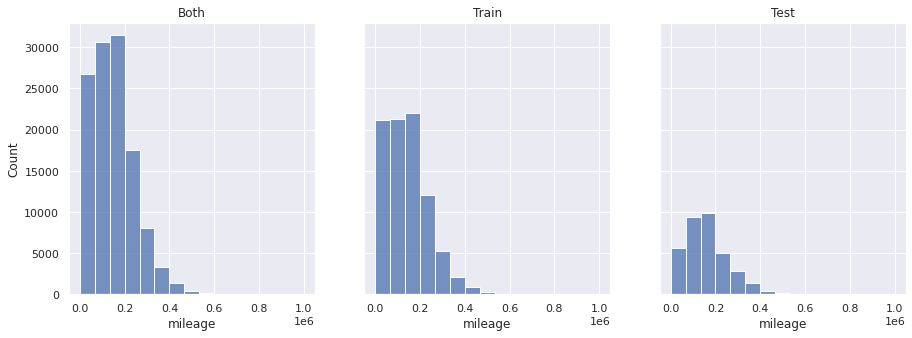

In [174]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.mileage, ax=ax[0], bins=15)
_ = sns.histplot(df[df.train == 1].mileage, ax=ax[1], bins=15)
_ = sns.histplot(df[df.train == 0].mileage, ax=ax[2], bins=15)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

In [175]:
len(df[df.mileage == 0])

10530

В датасете слишком много нулевых значений пробега. Но пробег сам по себе даже у новой машины не может быть нулевым и находится в интервале 15-20 км. Заменим все значения меньше 15 на случайные в данном интервале, но перед этим создадим новый признак, который будет обозначением нового авто без пробега

In [176]:
df['new_car?'] = df.mileage.apply(lambda x: 1 if x == 0 else 0)

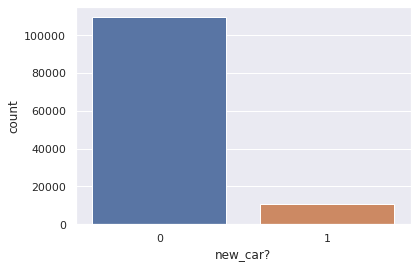

In [177]:
sns.countplot(df['new_car?'])

plt.show()

In [178]:
# Присвоим значениям меньше 15 км пробег от 15 до 20 км случайным образом

np.random.seed(RANDOM_SEED)

df['mileage'] = df.mileage.apply(lambda x: np.random.randint(15, 20) if x < 15 else x)

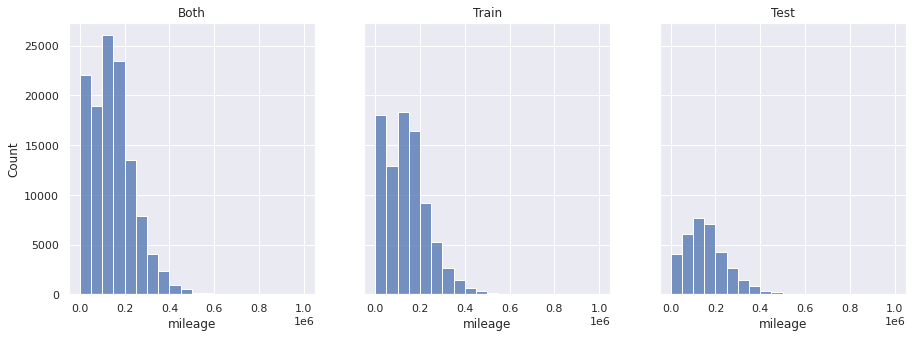

In [179]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.mileage, ax=ax[0], bins=20)
_ = sns.histplot(df[df.train == 1].mileage, ax=ax[1], bins=20)
_ = sns.histplot(df[df.train == 0].mileage, ax=ax[2], bins=20)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

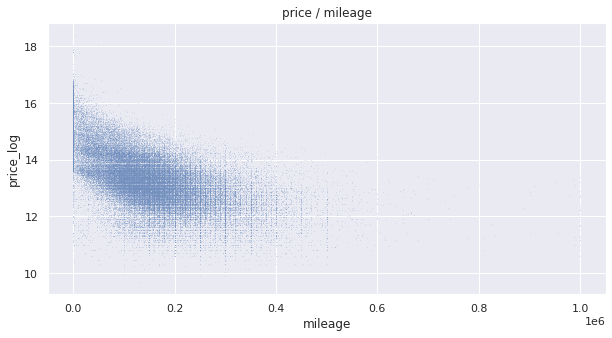

In [180]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'mileage', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=1)
g.set_title('price / mileage')
g.set_ylabel('price_log')
plt.show()

В данном случае чем больше пробег, тем, как правило, ниже цена.

Создадим признак mileage_per_age, который будет показывать, как интенсивно использовали автомобиль 

In [181]:
df['mileage_per_age'] = df.mileage / df.car_age

col_info(df['mileage_per_age'])

Количество пропусков: 0

count    120045.000000
mean      13103.158626
std        7813.846243
min           0.200000
25%        9000.000000
50%       12850.000000
75%       16923.076923
max      165667.000000
Name: mileage_per_age, dtype: float64

Распределение:
15.000000       1966
19.000000       1960
16.000000       1954
18.000000       1884
17.000000       1870
                ... 
11024.090909       1
16778.615385       1
12474.692308       1
23545.333333       1
9271.333333        1
Name: mileage_per_age, Length: 30509, dtype: int64



Удалим выбросы из трейна на оснований границ теста

In [182]:
# Получим максимальные и минимальные значения теста

test_mileage_per_age_max = df[df.train == 0].mileage_per_age.max()
test_mileage_per_age_min = df[df.train == 0].mileage_per_age.min()

print(test_mileage_per_age_max)
print(test_mileage_per_age_min)

110577.77777777778
0.2235294117647059


In [183]:
# Оставим значения по границам максимума и минимума

df = df[(df.mileage_per_age <= test_mileage_per_age_max) & (df.mileage_per_age >= test_mileage_per_age_min)]

col_info(df.mileage_per_age)

Количество пропусков: 0

count    120038.000000
mean      13098.135094
std        7770.266923
min           0.223529
25%        9000.000000
50%       12850.000000
75%       16923.076923
max      110577.777778
Name: mileage_per_age, dtype: float64

Распределение:
15.000000       1966
19.000000       1960
16.000000       1954
18.000000       1884
17.000000       1870
                ... 
8506.666667        1
18341.666667       1
18481.000000       1
11024.090909       1
9271.833333        1
Name: mileage_per_age, Length: 30502, dtype: int64



Посмотрим как изменились графики  по mileage и mileage_per_age

**mileage**

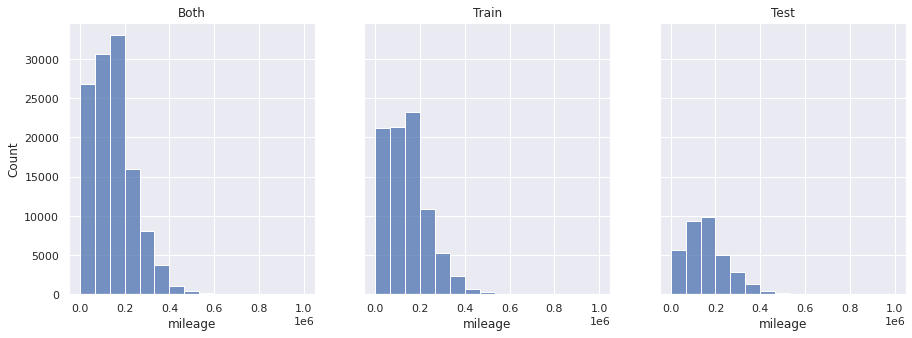

In [184]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.mileage, ax=ax[0], bins=15)
_ = sns.histplot(df[df.train == 1].mileage, ax=ax[1], bins=15)
_ = sns.histplot(df[df.train == 0].mileage, ax=ax[2], bins=15)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

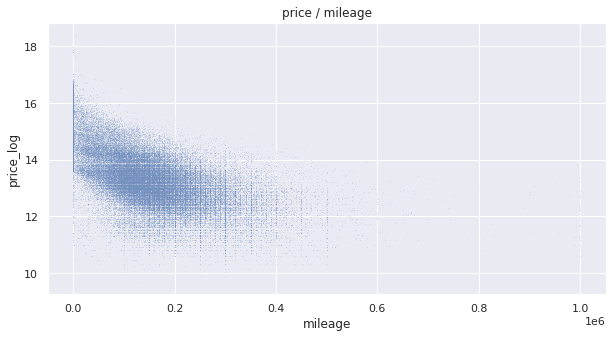

In [185]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'mileage', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=1)
g.set_title('price / mileage')
g.set_ylabel('price_log')
plt.show()

**mileage_per_age**

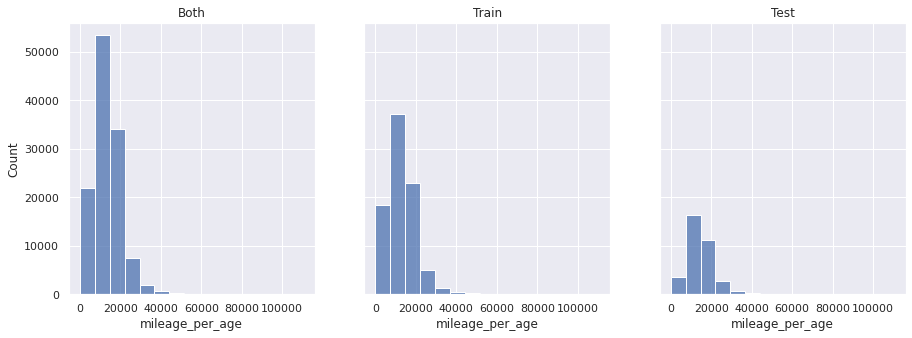

In [186]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 5)

_ = sns.histplot(df.mileage_per_age, ax=ax[0], bins=15)
_ = sns.histplot(df[df.train == 1].mileage_per_age, ax=ax[1], bins=15)
_ = sns.histplot(df[df.train == 0].mileage_per_age, ax=ax[2], bins=15)

ax[0].set_title('Both')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

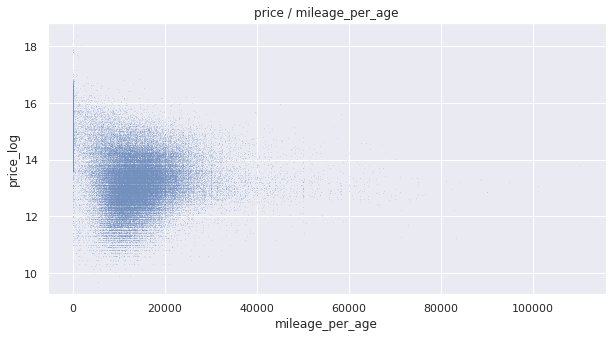

In [187]:
plt.figure(figsize=(10, 5))

g = sns.scatterplot(x = 'mileage_per_age', y = 'price_log', data = df[df.train == 1], alpha=0.2, s=1)
g.set_title('price / mileage_per_age')
g.set_ylabel('price_log')
plt.show()

Как видно из графика, интенсивность не сильно влияет на стоимость авто. Но мы посмотрим на это еще раз на этапе оценки полезности признаков

In [188]:
# Внесем данные признаки в наши списки
num_cols.append('mileage')
num_cols.append('mileage_per_age')
bin_cols.append('new_car?')

## 14. Привод

In [189]:
col_info(df['Привод'])

Количество пропусков: 0

count       120038
unique           3
top       передний
freq         61359
Name: Привод, dtype: object

Распределение:
передний    61359
полный      47690
задний      10989
Name: Привод, dtype: int64



In [190]:
# test

col_info(df[df.train==0]['Привод'])

Количество пропусков: 0

count        34686
unique           3
top       передний
freq         15565
Name: Привод, dtype: object

Распределение:
передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64



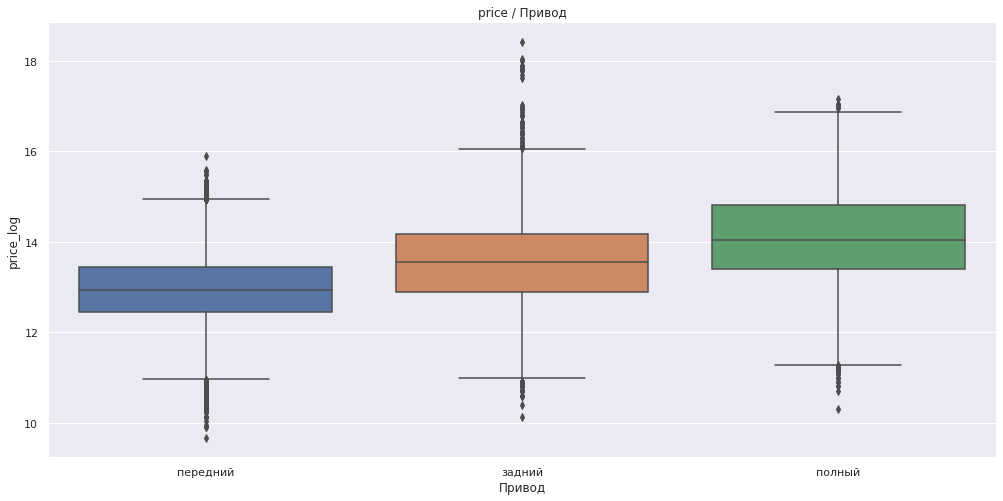

In [191]:
plt.figure(figsize=(17, 8))
order = df[df.train == 1].groupby('Привод').price_log.median().sort_values().index

g = sns.boxplot(x = 'Привод', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / Привод')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Как видно из графика, авто с полным приводом стоят дороже всего, в то время как авто с передним приводом дешевле всего

In [192]:
# Внесем данные признаки в наши списки

cat_cols.append('Привод')

## 15. Руль

In [193]:
col_info(df['Руль'])

Количество пропусков: 0

count     120038
unique         2
top        Левый
freq      116863
Name: Руль, dtype: object

Распределение:
Левый     116863
Правый      3175
Name: Руль, dtype: int64



In [194]:
# test

col_info(df[df.train==0]['Руль'])

Количество пропусков: 0

count     34686
unique        2
top       Левый
freq      33287
Name: Руль, dtype: object

Распределение:
Левый     33287
Правый     1399
Name: Руль, dtype: int64



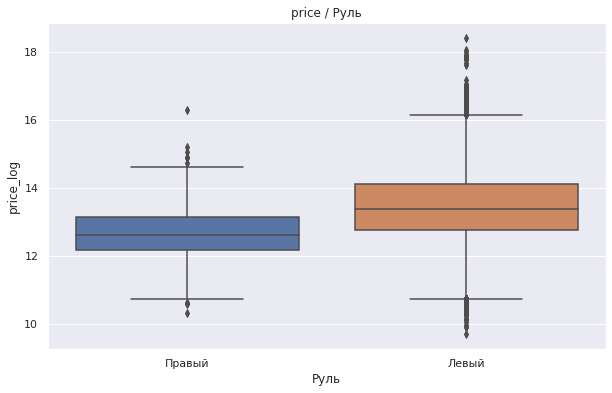

In [195]:
plt.figure(figsize=(10, 6))
order = df[df.train == 1].groupby('Руль').price_log.median().sort_values().index

g = sns.boxplot(x = 'Руль', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / Руль')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Леворульные авто как правило дороже праворульных

In [196]:
# Зададим значение для левого руля - 1, а для правого - 0

df['Руль'] = df['Руль'].apply(lambda x: 1 if x == 'Левый' else 0)

In [197]:
# Внесем данные признаки в наши списки

bin_cols.append('Руль')

## 16. Владельцы

In [198]:
col_info(df['Владельцы'])

Количество пропусков: 10530

count          109508
unique              3
top       3 или более
freq            51806
Name: Владельцы, dtype: object

Распределение:
3 или более    51806
2 владельца    30022
1 владелец     27680
Name: Владельцы, dtype: int64



In [199]:
# test

col_info(df[df.train==0]['Владельцы'])

Количество пропусков: 0

count           34686
unique              3
top       3 или более
freq            15957
Name: Владельцы, dtype: object

Распределение:
3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64



Заменим строковые значения на числовые

In [200]:
df['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

In [201]:
def num_from_owners(row):
    '''Функция вытаскивает число из строки'''
    
    row = str(row)
    result = re.findall('\d', row)
    if result == []:
        return None
    return result[0]

In [202]:
df['Владельцы'] = df['Владельцы'].apply(num_from_owners)

In [203]:
# Посмотрим на пропуски

df.loc[df['Владельцы'].isna()]

bodyType     brand  ... new_car? mileage_per_age
328         седан      AUDI  ...        1            18.0
329         седан      AUDI  ...        1            19.0
332         седан      AUDI  ...        1            17.0
335         седан      AUDI  ...        1            19.0
338         седан      AUDI  ...        1            19.0
...           ...       ...  ...      ...             ...
84306  минивэн xl  MERCEDES  ...        1            19.0
84308  минивэн xl  MERCEDES  ...        1            18.0
84311  минивэн xl  MERCEDES  ...        1            19.0
84448  минивэн l2  MERCEDES  ...        1            15.0
84454  минивэн l2  MERCEDES  ...        1             9.0

[10530 rows x 32 columns]

In [204]:
# По году производства можно судить что это новые авто, проверим

print(df.loc[df['Владельцы'].isna()]['new_car?'].unique())
print()
print(df.loc[df['Владельцы'].isna()].productionDate.describe())

[1]

count    10530.000000
mean      2019.897436
std          0.328648
min       2017.000000
25%       2020.000000
50%       2020.000000
75%       2020.000000
max       2020.000000
Name: productionDate, dtype: float64


Предположение подтвердилось, все авто с пропущенными значениями новые. Заменим тип значений на int и, добавив новое значение 0, поставим его вместо пропусков

In [205]:
df['Владельцы'].fillna(0, inplace=True)

In [206]:
df['Владельцы'] = df['Владельцы'].astype('int')

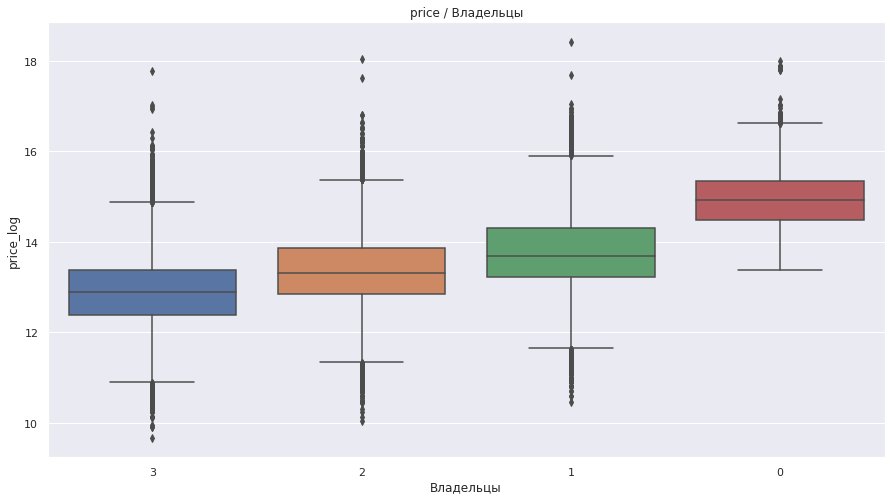

In [207]:
plt.figure(figsize=(15, 8))
order = df[df.train == 1].groupby('Владельцы').price_log.median().sort_values().index

g = sns.boxplot(x = 'Владельцы', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / Владельцы')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

График выглядит вполне логично. Чем меньше владельцев у авто, тем оно дороже. Фактически данный признак является категориальным порядковым.

In [208]:
# Внесем данные признаки в наши списки

ordinal_cat_cols.append('Владельцы')

## 17. ПТС

In [209]:
col_info(df['ПТС'])

Количество пропусков: 345

count       119693
unique           2
top       Оригинал
freq        104803
Name: ПТС, dtype: object

Распределение:
Оригинал    104803
Дубликат     14890
Name: ПТС, dtype: int64



In [210]:
# test

col_info(df[df.train==0]['ПТС'])

Количество пропусков: 1

count        34685
unique           2
top       Оригинал
freq         30098
Name: ПТС, dtype: object

Распределение:
Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64



In [211]:
# Посмотрим на пропуски

df.loc[df['ПТС'].isna()]

bodyType     brand  ... new_car? mileage_per_age
583                седан      AUDI  ...        1       16.000000
1510               седан      AUDI  ...        1       19.000000
1514               седан      AUDI  ...        1       19.000000
1524               седан      AUDI  ...        1       15.000000
2154               седан      AUDI  ...        1       18.000000
...                  ...       ...  ...      ...             ...
82065  внедорожник 5 дв.  MERCEDES  ...        1        6.333333
82954  внедорожник 5 дв.  MERCEDES  ...        1       15.000000
83999         седан long  MERCEDES  ...        1        9.000000
84205          минивэн l  MERCEDES  ...        1        7.500000
95802              седан       BMW  ...        0    12545.454545

[345 rows x 32 columns]

In [212]:
# По году производства можно судить что это новые авто, проверим

print(df.loc[df['ПТС'].isna()]['new_car?'].value_counts())
print()
print(df.loc[df['ПТС'].isna()].productionDate.describe())

1    344
0      1
Name: new_car?, dtype: int64

count     345.000000
mean     2019.811594
std         1.179714
min      1999.000000
25%      2020.000000
50%      2020.000000
75%      2020.000000
max      2020.000000
Name: productionDate, dtype: float64


324 новых авто и 1 выброс, посмотрим на него

In [213]:
df.loc[df['ПТС'].isna()][df['new_car?'] == 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


bodyType brand  color  ... enginePower_log  new_car?  mileage_per_age
95802    седан   BMW  синий  ...        5.135798         0     12545.454545

[1 rows x 32 columns]

In [214]:
df.loc[df['ПТС'].isna()][df['new_car?'] == 0].index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Int64Index([95802], dtype='int64')

In [215]:
# Так как данное значение находится в тесте, заменим его на самое частовстречаемое (Оригинал), а остальные заменим новым значение 'нет'

df.loc[95802, 'ПТС'] = 'Оригинал'
df['ПТС'].fillna('Нет', inplace=True)

In [216]:
# Проверим

col_info(df['ПТС'])

Количество пропусков: 0

count       120038
unique           3
top       Оригинал
freq        104804
Name: ПТС, dtype: object

Распределение:
Оригинал    104804
Дубликат     14890
Нет            344
Name: ПТС, dtype: int64



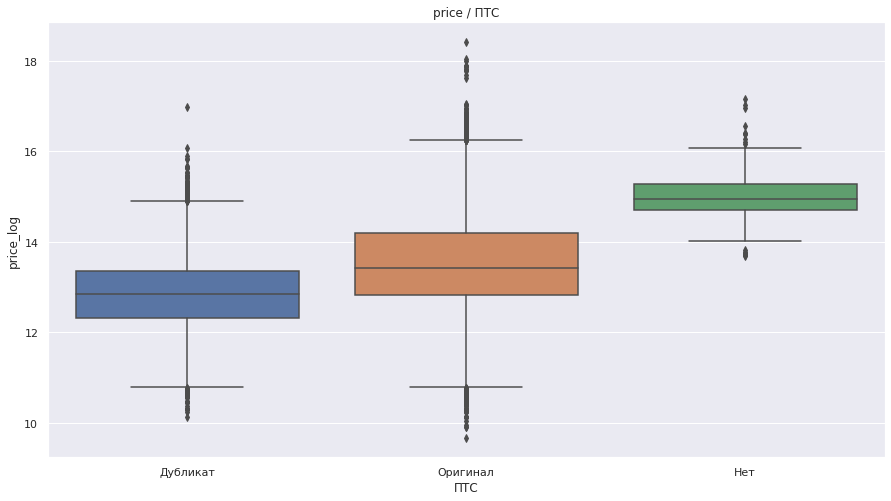

In [217]:
plt.figure(figsize=(15, 8))
order = df[df.train == 1].groupby('ПТС').price_log.median().sort_values().index

g = sns.boxplot(x = 'ПТС', y = 'price_log', data = df[df.train == 1], order=order)
g.set_title('price / ПТС')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с оригиналом птс дороже чем с дупликатом, в то же время авто без птс (новое) стоит дороже всего.

In [218]:
# Внесем данные признаки в наши списки

cat_cols.append('ПТС')

## 18. Владение

In [219]:
col_info(df['Владение'])

Количество пропусков: 79221

count                          40817
unique                           565
top       {'year': 2019, 'month': 8}
freq                             491
Name: Владение, dtype: object

Распределение:
{'year': 2019, 'month': 8}     491
{'year': 2018, 'month': 10}    491
{'year': 2018, 'month': 8}     485
{'year': 2018, 'month': 9}     470
{'year': 2018, 'month': 11}    469
                              ... 
{'year': 1998, 'month': 6}       1
{'year': 2003, 'month': 2}       1
16 лет и 3 месяца                1
29 лет и 11 месяцев              1
24 года и 2 месяца               1
Name: Владение, Length: 565, dtype: int64



In [220]:
col_info(df[df.train==0]['Владение'])

Количество пропусков: 22691

count                  11995
unique                   275
top       1 год и 10 месяцев
freq                     209
Name: Владение, dtype: object

Распределение:
1 год и 10 месяцев     209
2 года                 197
1 год                  194
1 год и 1 месяц        193
1 год и 2 месяца       187
                      ... 
29 лет и 11 месяцев      1
19 лет и 7 месяцев       1
16 лет и 3 месяца        1
21 год и 9 месяцев       1
20 лет и 5 месяцев       1
Name: Владение, Length: 275, dtype: int64



In [221]:
len(df['Владение'])

120038

В признаке слишком много пропусков. Не знаю как можно его использовать в данном случае. Удалим.

In [222]:
# Дропаем признак владения

df.drop(columns='Владение', inplace=True)

## 19. model_name

In [223]:
col_info(df.model_name)

Количество пропусков: 0

count      120038
unique       1100
top       octavia
freq         2814
Name: model_name, dtype: object

Распределение:
octavia     2814
5er         2637
focus       2455
e_klasse    2182
passat      2154
            ... 
tuscani        1
tacoma         1
olympia        1
torneo         1
roomy          1
Name: model_name, Length: 1100, dtype: int64



In [224]:
# train

col_info(df[df.train==1].model_name)

Количество пропусков: 0

count     85352
unique     1082
top       focus
freq       2455
Name: model_name, dtype: object

Распределение:
focus          2455
solaris        1656
5er            1611
astra          1540
rio            1436
               ... 
n_one             1
w114              1
yaris_verso       1
20                1
aerostar          1
Name: model_name, Length: 1082, dtype: int64



In [225]:
# test

col_info(df[df.train==0].model_name)

Количество пропусков: 0

count       34686
unique        544
top       octavia
freq         1418
Name: model_name, dtype: object

Распределение:
octavia      1418
5er          1026
lancer        855
e_klasse      809
passat        782
             ... 
president       1
e3              1
fto             1
aygo            1
presea          1
Name: model_name, Length: 544, dtype: int64



Уникальных значений модели авто в тесте в два раза меньше чем в трейне. Оставим в тренировочной части значения по тесту, остальные закинем в значение *other*

In [226]:
model_name_test = list(df[df.train==0].model_name.unique())

In [227]:
df['model_name'] = df.model_name.apply(lambda x: x if x in model_name_test else 'other')

In [228]:
# Внесем данные признаки в наши списки

cat_cols.append('model_name')

## 20. description

In [229]:
# train

col_info(df[df.train==1].description)

Количество пропусков: 3210

count                                                 82142
unique                                                77159
top       РОЛЬФ Северо-Запад - это первый мегамолл автом...
freq                                                    244
Name: description, dtype: object

Распределение:
РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с пробегом, где на площади 27 000 кв.м. вас ждут 1 500 автомобилей с комфортными условиями покупки и выгодными предложениями.· Все автомобили проверены по стандартам РОЛЬФ и заводов-изготовителей· Более 50 брендов в различных ценовых категориях· Возможность приобретения выбранного автомобиля в кредит (более 10 Банков-партнеров: ЮниКредитБанк, Экспо Банк, Тинькофф Банк, Совкомбанк, Сетелем, Русфинанс Банк, Росгосстрах банк, МС Банк, Локо Банк ,Кредит Европа Банк, ВТБ, Банк УРАЛСИБ, Банк Союз, Банк Зенит, Балтинвестбанк).· Любые виды страхования автомобилей· Услуги ГИБДД (поставка на учет, прекращение учета, сохранение госуд

In [230]:
# test

col_info(df[df.train==0].description)

Количество пропусков: 0

count                                                 34686
unique                                                31732
top       Выгода до 82 000 руб. при обмене на Ваш автомо...
freq                                                    264
Name: description, dtype: object

Распределение:
Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Ср

In [231]:
# заполним пропуски

df['description'] = df.description.fillna(' ')

In [232]:
# Для удобства присвоим столбец новой переменной

data = df['description']

In [233]:
data

0          Машина  в приличном состоянии ,не гнилая не р...
1         Машина в оригинале не гнилая все вопросы по те...
2         ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
3                                                          
4         Машина не гнилая, дыр нет, днище целое, даже в...
                                ...                        
120071    Продается BMW 316i в отличном состоянии. Прода...
120072                       Продаётся отличный автомобиль.
120073                                    Хорошее состояние
120074    Автомобиль в идеальном состоянии . Куплен новы...
120075     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 120038, dtype: object

In [234]:
# Переведем текст в нижний регистр

data = data.str.lower()

In [235]:
# Удалим символ переноса строки, табуляции и странную точку найденную в данных

symbols = ['\n', '\t', '•']

for pat in symbols:
    data = data.str.replace(pat,' ')

In [236]:
# Удалим все численные обозначения

for pat in range(10):
    data = data.str.replace(str(pat),' ')

In [237]:
# Удалим иностранные символы (латынь)

data = data.str.replace(r'[a-z]',' ')

In [238]:
# Удалим знаки пунктуации

for pat in punctuation:
    data = data.str.replace(pat,' ')

In [239]:
# Опытным путем выяснилось, что необходимо повторно пройтись данной функцией для очистки данных от всех "не буквенных" символов

def clean_symbs(data):
    clean = re.sub(r"[^\w]", " ", data)
    return clean

data = data.apply(clean_symbs)

In [240]:
# Выбираем только те строки, которые не состоят полностью из пробельных символов (не пустые)

data = data[~data.str.isspace()]

In [241]:
def without_space(data):
    '''Функция для очистки строки от лишних пробелов'''
    a = re.sub(r'\s+', ' ', data)
    return a

data = data.apply(without_space)

In [243]:
# Удалим пробелы по краям строк

data = data.str.strip(' ')

In [244]:
# Создаем лист стоп слов

russian_stopwords = stopwords.words("russian")

In [245]:
mystem = Mystem() 

# В функции с предобработкой пришлось снова писать код для очистки от пунктуации, так как некоторые символы до конца не хотели удаляться

def preprocess_text(text):
    '''Функция для лемматизации текста, очистки от стоп-слов и разделения на токены'''
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " "\
              and token.strip() not in punctuation]
  
    return tokens

In [247]:
data = data.apply(preprocess_text)

In [248]:
counter = Counter()
def count_words(sentence):
    global counter
    for x in sentence:
        counter[x] += 1

In [249]:
data.apply(count_words)

0         None
1         None
2         None
4         None
5         None
          ... 
120071    None
120072    None
120073    None
120074    None
120075    None
Name: description, Length: 116746, dtype: object

In [250]:
# Посмотрим на наиболее встречающиеся значения, а так же проверим результат работы функции

counter.most_common(n=500)

[('автомобиль', 191929),
 ('система', 156683),
 ('задний', 134956),
 ('сидение', 130615),
 ('передний', 113387),
 ('салон', 87938),
 ('весь', 74272),
 ('безопасность', 66675),
 ('состояние', 64546),
 ('год', 61786),
 ('зеркало', 60244),
 ('диск', 58685),
 ('машина', 58557),
 ('фара', 56005),
 ('водитель', 53662),
 ('пробег', 53223),
 ('контроль', 52538),
 ('пассажир', 49260),
 ('цвет', 47818),
 ('новый', 46575),
 ('подушка', 46377),
 ('колесо', 46318),
 ('стекло', 43926),
 ('датчик', 43478),
 ('руль', 42826),
 ('кредит', 42790),
 ('обогрев', 40342),
 ('кузов', 40176),
 ('комплектация', 39512),
 ('авто', 38964),
 ('комплект', 38654),
 ('дверь', 38357),
 ('ваш', 37995),
 ('рулевой', 37984),
 ('подогрев', 37715),
 ('регулировка', 37418),
 ('центральный', 36516),
 ('двигатель', 36370),
 ('покупка', 35695),
 ('черный', 34784),
 ('пакет', 34499),
 ('хороший', 34338),
 ('электропривод', 33975),
 ('вид', 33471),
 ('боковой', 33471),
 ('шина', 33261),
 ('функция', 32369),
 ('дилер', 32108),
 ('

In [251]:
df['description_tokens'] = data

In [252]:
df.description_tokens.isna().sum()

3292

In [253]:
df['description_tokens'].fillna('', inplace=True)
df['description_tokens']

0         [машина, приличный, состояние, гнилой, ржавый,...
1         [машина, оригинал, гнилой, весь, вопрос, телеф...
2         [птс, оригинал, полный, комплект, ключ, резуль...
3                                                          
4         [машина, гнилой, дыра, днище, целый, родной, к...
                                ...                        
120071    [продаваться, отличный, состояние, продаваться...
120072                  [продаваться, отличный, автомобиль]
120073                                 [хороший, состояние]
120074    [автомобиль, идеальный, состояние, купить, нов...
120075    [пробег, реальный, состояние, отличный, авторс...
Name: description_tokens, Length: 120038, dtype: object

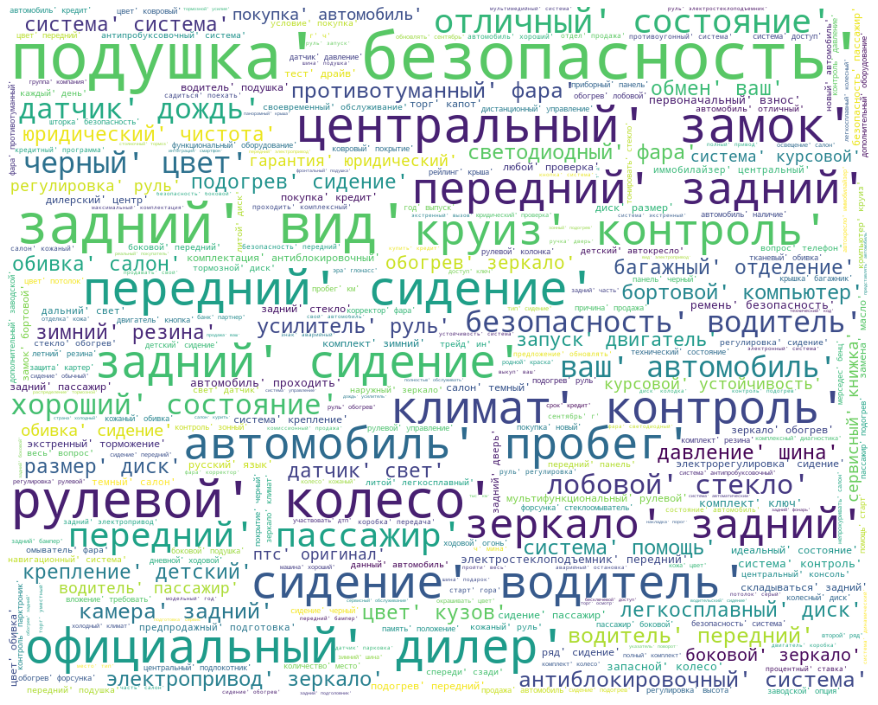

In [254]:
# Посмотрим на самые частовстречающиеся теги

wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=RANDOM_SEED,
).generate(" ".join(df['description_tokens'].astype(str)))

plt.figure(figsize = (12, 14), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [255]:
# Создадим новые признаки на основании сочетаний слов, которые могут влиять на цену авто

# Подушка безопасности
df['airbag'] = df.description_tokens.apply(lambda x: 1 if ('подушка' and 'безопасность') in x else 0)

# Отличное состояние
df['excellent_condition'] = df.description_tokens.apply(lambda x: 1 if ('отличный' and 'состояние') in x else 0)

# Легкосплавные диски
df['alloy_wheels'] = df.description_tokens.apply(lambda x: 1 if ('легкосплавный' and 'диск') in x else 0)

# Обогрев зеркал
df['heated_mirrors'] = df.description_tokens.apply(lambda x: 1 if ('обогрев' and 'зеркало') in x else 0)

# Центральный замок
df['central_locking'] = df.description_tokens.apply(lambda x: 1 if ('центральный' and 'замок') in x else 0)

# Бортовой компьютер
df['on-board_computer'] = df.description_tokens.apply(lambda x: 1 if ('бортовой' and 'компьютер') in x else 0)

# АБС
df['abs'] = df.description_tokens.apply(lambda x: 1 if ('антиблокировочный' and 'система') in x else 0)

# Датчик света
df['light_sensor'] = df.description_tokens.apply(lambda x: 1 if ('датчик' and 'свет') in x else 0)

# Обивка салона
df['upholstery'] = df.description_tokens.apply(lambda x: 1 if ('обивка' and 'салон') in x else 0)

# Подогрев сидения
df['heated_seat'] = df.description_tokens.apply(lambda x: 1 if ('подогрев' and 'сидение') in x else 0)

# Датчик дождя
df['rain_sensor'] = df.description_tokens.apply(lambda x: 1 if ('датчик' and 'дождь') in x else 0)

# Официальный диллер
df['official_dealer'] = df.description_tokens.apply(lambda x: 1 if ('официальный' and 'диллер') in x else 0)

# Хорошее состояние
df['good_condition'] = df.description_tokens.apply(lambda x: 1 if ('хороший' and 'состояние') in x else 0)

# Усилитель руля
df['power_steering'] = df.description_tokens.apply(lambda x: 1 if ('усилитель' and 'руль') in x else 0)

# Круиз контроль
df['сruise_control'] = df.description_tokens.apply(lambda x: 1 if ('круиз' and 'контроль') in x else 0)

# Климат контроль
df['climate_control'] = df.description_tokens.apply(lambda x: 1 if ('климат' and 'контроль') in x else 0)

# Светодиодные фары
df['led_lights'] = df.description_tokens.apply(lambda x: 1 if ('светодиодный' and 'фара') in x else 0)

# Противотуманные фары
df['fog_lights'] = df.description_tokens.apply(lambda x: 1 if ('противотуманный' and 'фара') in x else 0)

# Камера заднего вида
df['rv_camera'] = df.description_tokens.apply(lambda x: 1 if ('камера' and 'задний') in x else 0)

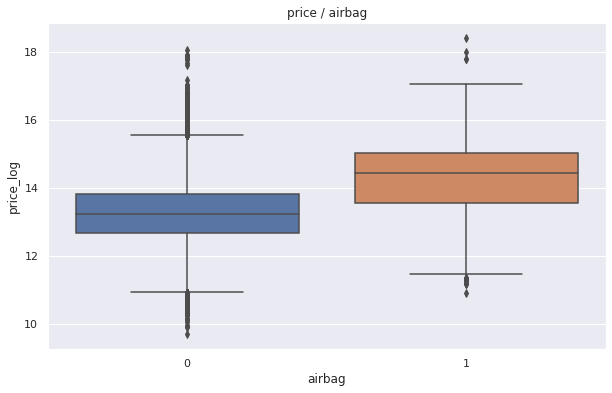

In [256]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'airbag', y = 'price_log', data = df[df.train == 1])
g.set_title('price / airbag')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием в описании наличия подушки безопасности обычно стоят дороже чем без него

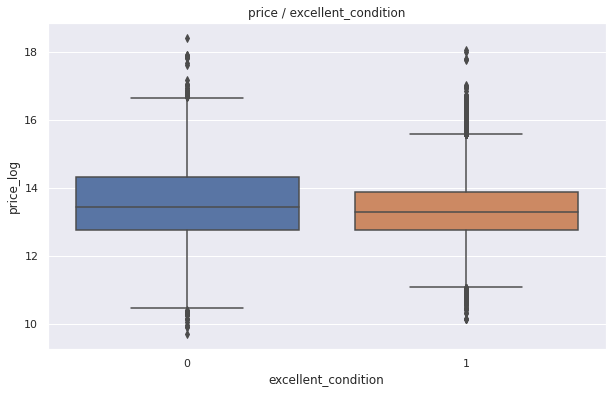

In [257]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'excellent_condition', y = 'price_log', data = df[df.train == 1])
g.set_title('price / excellent_condition')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Усредненные значения цен практически не отличаются. В случае отличного состояния цена чуть ниже и меньше разброс стоимости

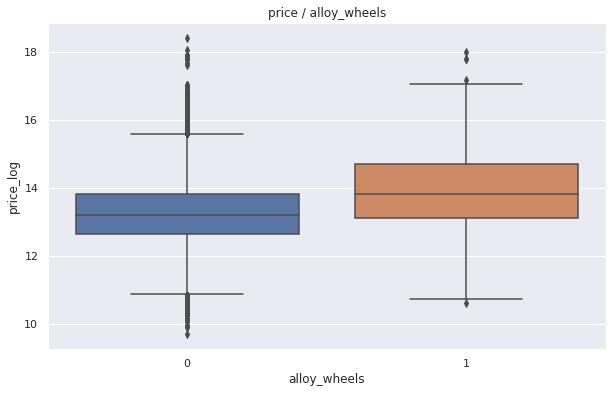

In [258]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'alloy_wheels', y = 'price_log', data = df[df.train == 1])
g.set_title('price / alloy_wheels')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Чаще всего авто с легкосплавными дисками стоит дороже

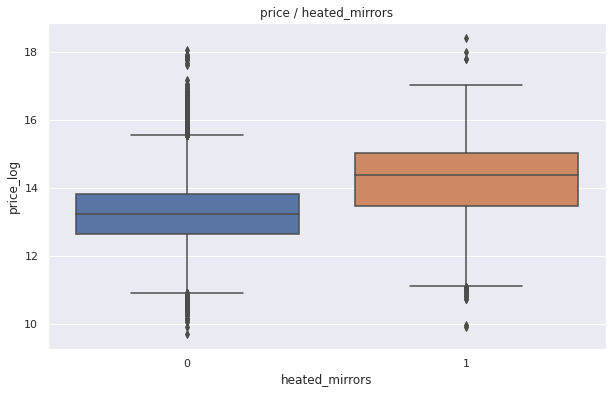

In [259]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'heated_mirrors', y = 'price_log', data = df[df.train == 1])
g.set_title('price / heated_mirrors')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Чаще всего авто с обогревом зеркал стоит дороже

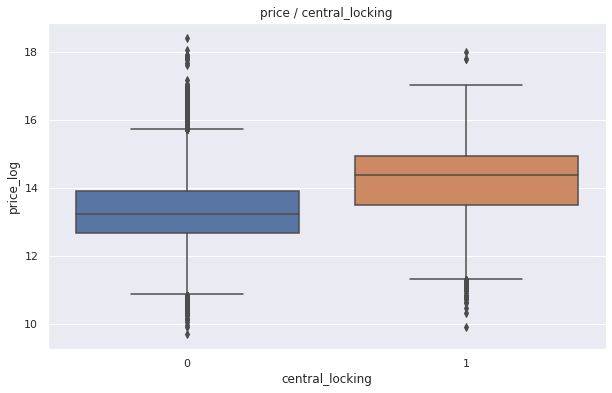

In [260]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'central_locking', y = 'price_log', data = df[df.train == 1])
g.set_title('price / central_locking')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием центрального замка дороже

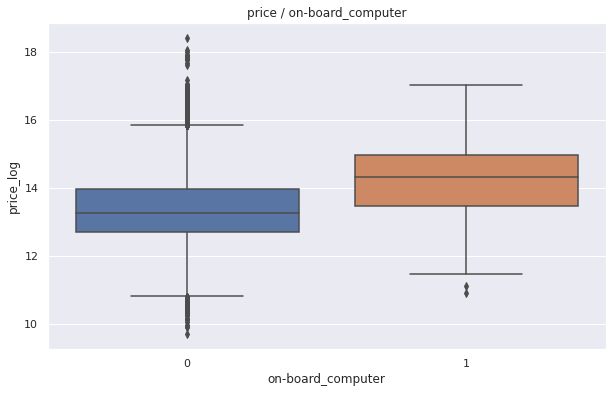

In [261]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'on-board_computer', y = 'price_log', data = df[df.train == 1])
g.set_title('price / on-board_computer')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием бортового компьютера зачастую дороже чем без него

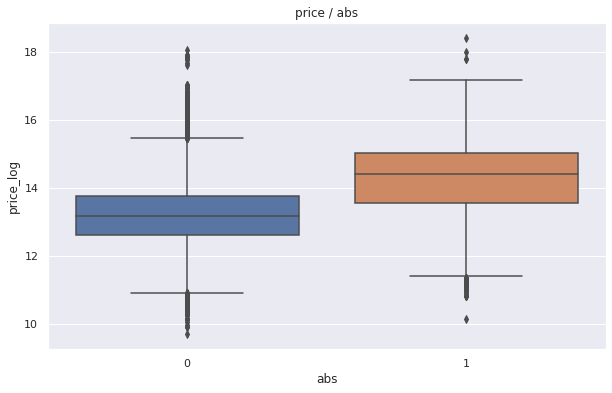

In [262]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'abs', y = 'price_log', data = df[df.train == 1])
g.set_title('price / abs')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием антиблокировочной системы зачастую дороже чем без него

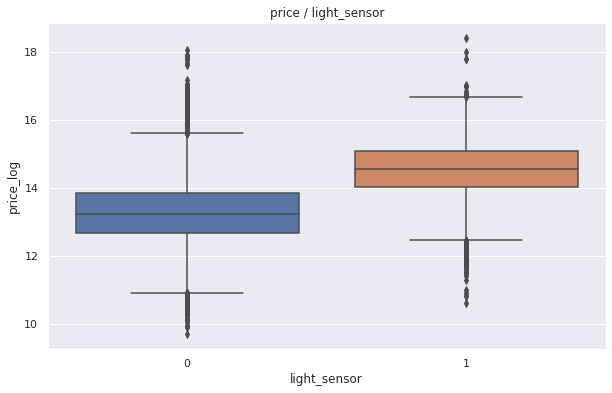

In [263]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'light_sensor', y = 'price_log', data = df[df.train == 1])
g.set_title('price / light_sensor')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с датчиком света также выше по стоимости чем без него

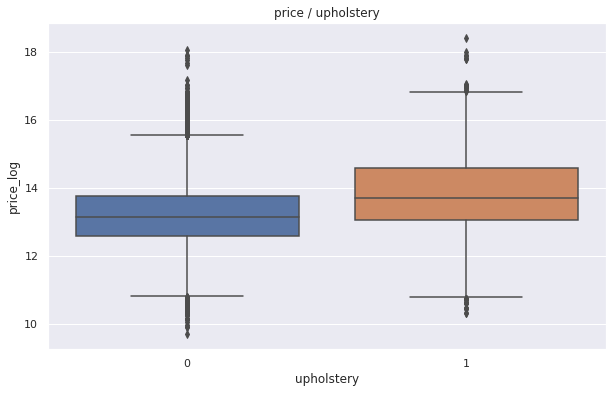

In [264]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'upholstery', y = 'price_log', data = df[df.train == 1])
g.set_title('price / upholstery')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием обивки салона дороже

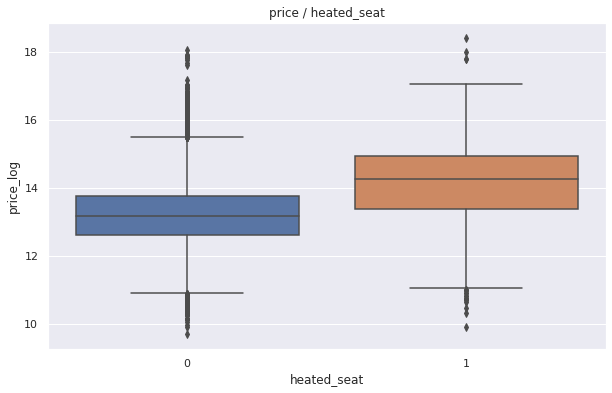

In [265]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'heated_seat', y = 'price_log', data = df[df.train == 1])
g.set_title('price / heated_seat')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием подогрева сидений дороже

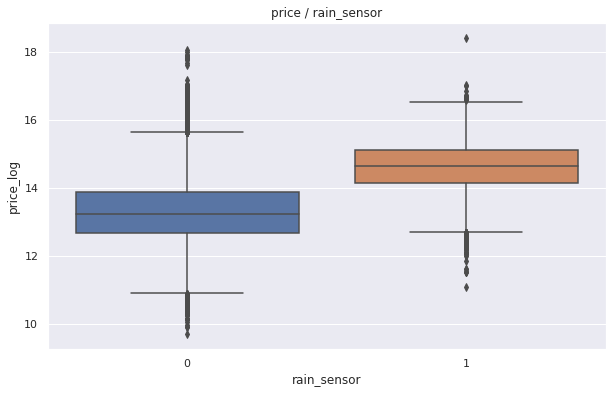

In [266]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'rain_sensor', y = 'price_log', data = df[df.train == 1])
g.set_title('price / rain_sensor')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием датчика дождя выше по стоимости

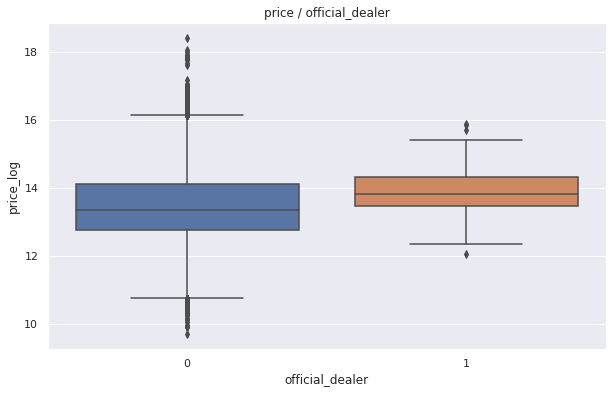

In [267]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'official_dealer', y = 'price_log', data = df[df.train == 1])
g.set_title('price / official_dealer')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминанием официального диллера в описании стоит дороже

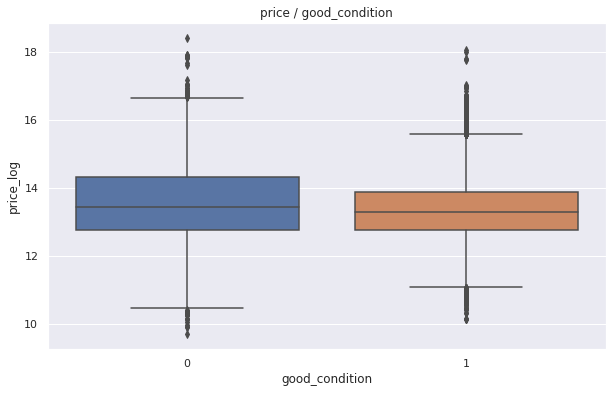

In [268]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'good_condition', y = 'price_log', data = df[df.train == 1])
g.set_title('price / good_condition')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Та же ситуация, что и с "отличным состоянием". Скорее всего придется удалить оба признака

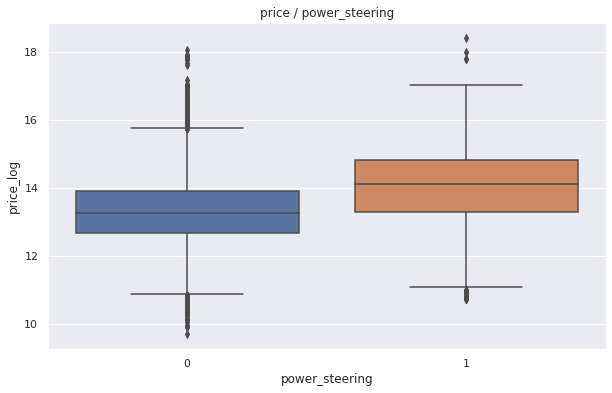

In [269]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'power_steering', y = 'price_log', data = df[df.train == 1])
g.set_title('price / power_steering')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с усилителем руля выше по стоимости

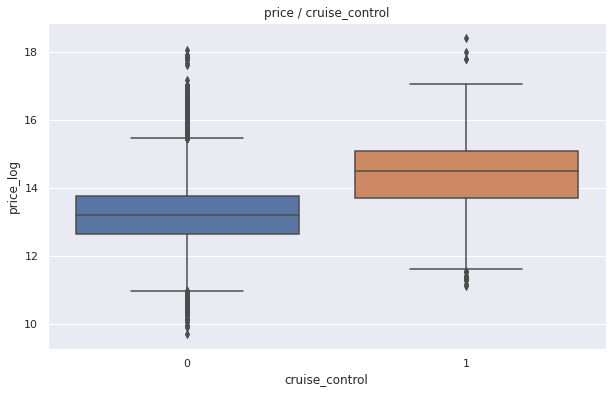

In [270]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'сruise_control', y = 'price_log', data = df[df.train == 1])
g.set_title('price / сruise_control')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с круиз-контролем выше в цене

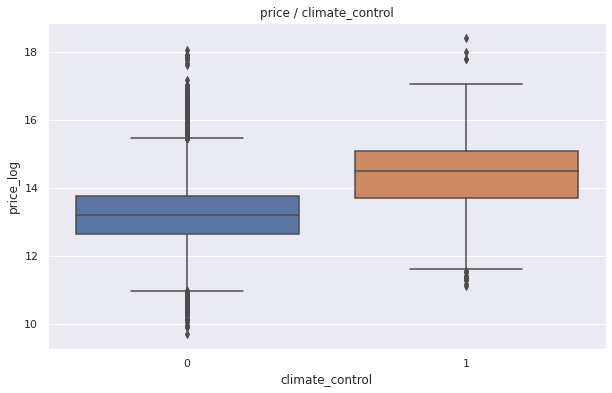

In [271]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'climate_control', y = 'price_log', data = df[df.train == 1])
g.set_title('price / climate_control')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Авто с упоминание климат-контроля выше по стоимости

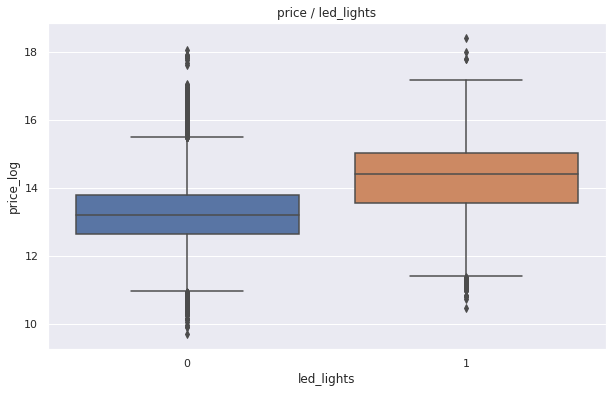

In [272]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'led_lights', y = 'price_log', data = df[df.train == 1])
g.set_title('price / led_lights')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Присутствие светодиодных фар в описании чаще всего повышает стоимость авто

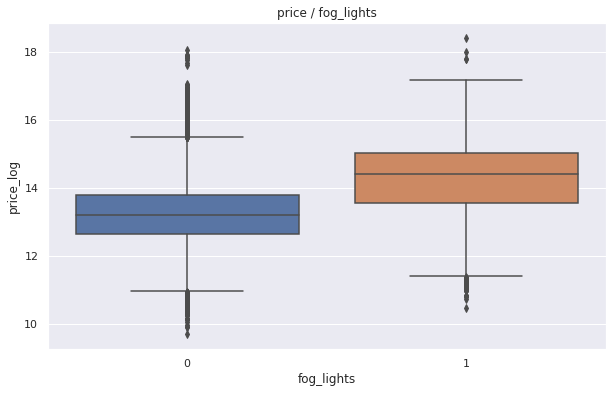

In [273]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'fog_lights', y = 'price_log', data = df[df.train == 1])
g.set_title('price / fog_lights')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Такая же ситуация как и со светодиодными фарами

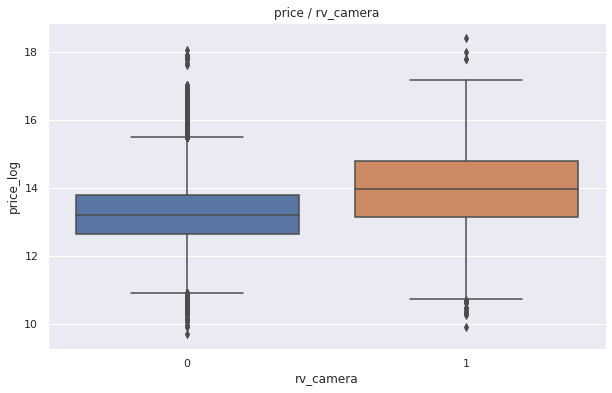

In [274]:
plt.figure(figsize=(10, 6))

g = sns.boxplot(x = 'rv_camera', y = 'price_log', data = df[df.train == 1])
g.set_title('price / rv_camera')
g.set_ylabel('price_log')
g.set_xticklabels(g.get_xticklabels())

plt.show()

Упоминание камеры заднего вида так же повышает цену автомобиля

In [275]:
# Добавим так же новые признаки для количества слов, символов и средней длины слова
# Количество слов в строке
df['word_count'] = df.description_tokens.apply(lambda x: len(x))

# Количество символов в строке
df['char_count'] = df.description_tokens.apply(lambda x: sum(len(word) for word in x))

# Средняя длина слова в строке
df['avg_word_length'] = df['char_count'] / df['word_count']
df.avg_word_length.fillna(0, inplace=True)

In [276]:
# Удалим признаки отличного и хорошего состояния, т.к. они практически не влияют на цену

df.drop(columns=['excellent_condition', 'good_condition'], inplace=True)

In [277]:
df.description_tokens.apply(count_words)

0         None
1         None
2         None
3         None
4         None
          ... 
120071    None
120072    None
120073    None
120074    None
120075    None
Name: description_tokens, Length: 120038, dtype: object

In [278]:
counter.most_common(n=100)

[('автомобиль', 383858),
 ('система', 313366),
 ('задний', 269912),
 ('сидение', 261230),
 ('передний', 226774),
 ('салон', 175876),
 ('весь', 148544),
 ('безопасность', 133350),
 ('состояние', 129092),
 ('год', 123572),
 ('зеркало', 120488),
 ('диск', 117370),
 ('машина', 117114),
 ('фара', 112010),
 ('водитель', 107324),
 ('пробег', 106446),
 ('контроль', 105076),
 ('пассажир', 98520),
 ('цвет', 95636),
 ('новый', 93150),
 ('подушка', 92754),
 ('колесо', 92636),
 ('стекло', 87852),
 ('датчик', 86956),
 ('руль', 85652),
 ('кредит', 85580),
 ('обогрев', 80684),
 ('кузов', 80352),
 ('комплектация', 79024),
 ('авто', 77928),
 ('комплект', 77308),
 ('дверь', 76714),
 ('ваш', 75990),
 ('рулевой', 75968),
 ('подогрев', 75430),
 ('регулировка', 74836),
 ('центральный', 73032),
 ('двигатель', 72740),
 ('покупка', 71390),
 ('черный', 69568),
 ('пакет', 68998),
 ('хороший', 68676),
 ('электропривод', 67950),
 ('вид', 66942),
 ('боковой', 66942),
 ('шина', 66522),
 ('функция', 64738),
 ('дилер',

In [279]:
def find_threshold(value=3):
    '''Функция устанавливает порог по количеству уникального слова в признаке и выводит индекс порогового значения функции counter'''
    for n, (word, count) in enumerate(counter.most_common()):
        if count == value:
            return n

In [280]:
# Найдем индекс по порогу в 150 слов, чтобы исключить мусор и грамматические ошибки

find_threshold(150)

4586

In [281]:
# Создадим словарь отфильтрованных слов

words_filtred = dict(counter.most_common(4586))

In [282]:
# Оставим в нашем признаке только те слова, которые прошли по порогу

df.description_tokens = df.description_tokens.apply(lambda x: [word for word in x if word in words_filtred])

In [283]:
# При помощи TfidfVectorizer создадим матрицу tf-idf значений для каждого слова

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform([" ".join(x) for x in df.description_tokens.values])

In [284]:
# Для наглядности результата создадим датафрейм

tfidf_tokens = tfidf_vectorizer.get_feature_names()
tfidf_array = tfidf.toarray()
df_tfidfvect = pd.DataFrame(data = tfidf_array,columns = tfidf_tokens)

In [285]:
df_tfidfvect

абс  абсолютно  абсолютный  ава  ...  ярославский  ясенево  ясень  ящик
0       0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
1       0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
2       0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
3       0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
4       0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
...     ...        ...         ...  ...  ...          ...      ...    ...   ...
120033  0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
120034  0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
120035  0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
120036  0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0
120037  0.0        0.0         0.0  0.0  ...          0.0      0.0    0.0   0.0

[120038 rows x 4565 columns]

In [286]:
# Создадим модель TSVD с 10 компонентами

TSVD = TruncatedSVD(n_components=10, random_state=RANDOM_SEED)

TSVD.fit(tfidf_array)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5, random_state=42,
             tol=0.0)

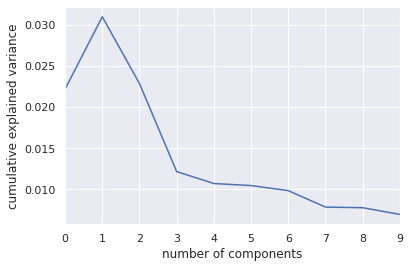

In [287]:
# Воспользуемся методом локтя, чтобы вычислить оптимальное число компонент

plt.plot(TSVD.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim((0, 9))
plt.show()

In [288]:
# Снова создадим модель TSVD уже с найденным количеством компонент и обучим нашу матрицу

TSVD = TruncatedSVD(n_components=4, random_state=RANDOM_SEED)

TSVD.fit(tfidf_array)

TruncatedSVD(algorithm='randomized', n_components=4, n_iter=5, random_state=42,
             tol=0.0)

In [289]:
TSVD.explained_variance_ratio_

array([0.02218573, 0.03098155, 0.02285884, 0.01215396])

In [290]:
# Уменьшаем размерность нашей tf-idf матрицы до 4 столбцов

TSVD_features = TSVD.transform(tfidf_array)

In [291]:
TSVD_features

array([[ 0.13431744, -0.08059782, -0.0812636 , -0.03279594],
       [ 0.12733546, -0.18294431, -0.10799315,  0.11011932],
       [ 0.44632245,  0.08100544,  0.31019987,  0.02727614],
       ...,
       [ 0.15010477, -0.30648943, -0.14852954,  0.43782914],
       [ 0.31420245, -0.06469374, -0.09738975,  0.05666334],
       [ 0.16160483, -0.22042711, -0.07996223, -0.00970107]])

In [292]:
# Добавим новые признаки в списки

bin_cols.extend(['airbag', 'alloy_wheels', 'heated_mirrors', 'central_locking', 'on-board_computer', 'abs', 
                 'light_sensor', 'upholstery', 'heated_seat', 'rain_sensor', 'official_dealer', 'power_steering', 
                 'сruise_control', 'climate_control', 'led_lights', 'fog_lights', 'rv_camera'])
num_cols.extend(['word_count', 'char_count', 'avg_word_length'])

##21. complectation_dict

In [293]:
col_info(df.complectation_dict)

Количество пропусков: 0

count          120038
unique           8185
top       {'id': '0'}
freq            86649
Name: complectation_dict, dtype: object

Распределение:
{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [294]:
# Удалим данный признак так как в тесте было изначально слишком много пропусков, плюс на данный момент я не представляю как сейчас можно с пользой его обработать

df.drop(columns=['complectation_dict'], inplace=True)

## Сохранение датасета после EDA

In [295]:
df.sample(3)

bodyType  brand   color  ... word_count  char_count  avg_word_length
40561    хэтчбек 3 дв.  other   серый  ...        144        1078         7.486111
60678  универсал 5 дв.  other  чёрный  ...        409        3134         7.662592
86496          лифтбек  SKODA   серый  ...         20         151         7.550000

[3 rows x 51 columns]

In [296]:
cols_to_drop = ['bodyType', 'engineDisplacement2', 'description', 'description_tokens']
                
for col in cols_to_drop:
    if col in list(df.columns):
        df.drop(columns=col, inplace=True)

In [297]:
df.sample(3)

brand      color fuelType  ...  word_count  char_count  avg_word_length
18909        other     чёрный   бензин  ...           0           0         0.000000
36743        other  оранжевый   бензин  ...          39         278         7.128205
109823  VOLKSWAGEN     чёрный   бензин  ...          71         486         6.845070

[3 rows x 47 columns]

In [298]:
target_cols = ['price', 'price_log']

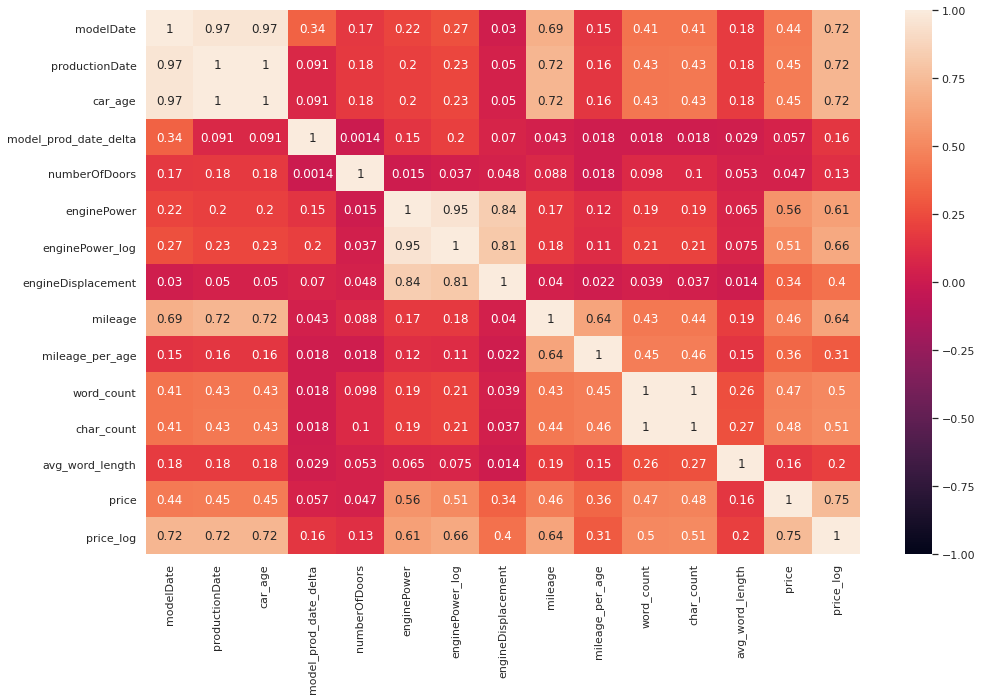

In [299]:
plt.figure(figsize=(16,10))
sns.heatmap(df[df.train==1][num_cols+target_cols].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

modelDate, productionDate и car_age сильно скореллированны между собой, так же как и enginePower, enginePower_log  и word_count, char_count. Посмотрим значимость данных признаков через ANOVA f-test , чтобы решить, какой из них удалить.

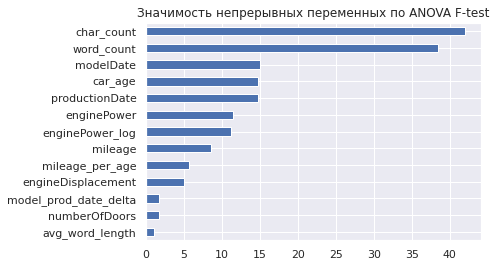

In [300]:
imp_num = pd.Series(f_classif(df[df.train==1][num_cols], df[df.train==1]['price_log'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F-test')

plt.show()

Удалим признаки productionDate и enginePower из нашего датасета

In [301]:
num_cols.remove('productionDate')
num_cols.remove('enginePower')
num_cols.remove('word_count')
num_cols.remove('car_age')

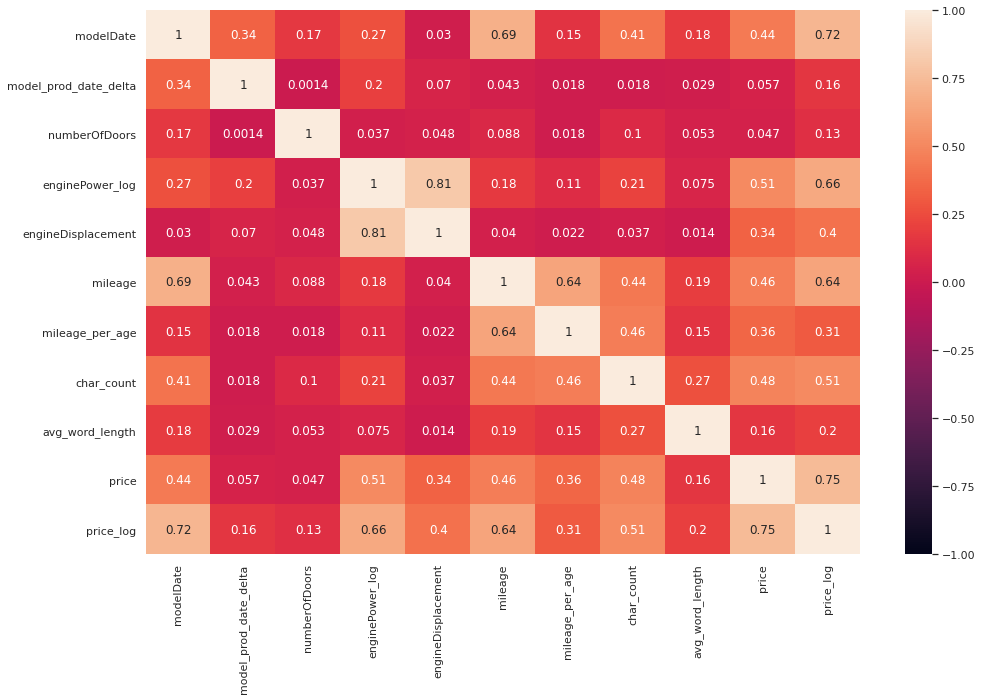

In [302]:
plt.figure(figsize=(16,10))
sns.heatmap(df[df.train==1][num_cols+target_cols].corr().abs(), vmin=-1, vmax=1, annot=True)
plt.show()

In [303]:
train_col = ['train']

In [304]:
sum_cols = num_cols+cat_cols+bin_cols+ordinal_cat_cols+target_cols+train_col

df_1 = df.loc[:, sum_cols].copy()

# Data Preprocessing

In [305]:
df_1[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120038 entries, 0 to 120075
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   modelDate              120038 non-null  int64  
 1   model_prod_date_delta  120038 non-null  int64  
 2   numberOfDoors          120038 non-null  int64  
 3   enginePower_log        120038 non-null  float64
 4   engineDisplacement     120038 non-null  float64
 5   mileage                120038 non-null  int64  
 6   mileage_per_age        120038 non-null  float64
 7   char_count             120038 non-null  int64  
 8   avg_word_length        120038 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 14.2 MB


In [306]:
df_1[num_cols].values

array([[1.99000000e+03, 1.00000000e+00, 4.00000000e+00, ...,
        1.16666667e+04, 1.46000000e+02, 6.63636364e+00],
       [1.98200000e+03, 4.00000000e+00, 4.00000000e+00, ...,
        4.95497143e+03, 8.80000000e+01, 6.28571429e+00],
       [1.98800000e+03, 1.00000000e+00, 5.00000000e+00, ...,
        7.18750000e+03, 8.35000000e+02, 7.80373832e+00],
       ...,
       [1.99500000e+03, 2.00000000e+00, 4.00000000e+00, ...,
        1.50000000e+04, 1.60000000e+01, 8.00000000e+00],
       [2.01200000e+03, 1.00000000e+00, 5.00000000e+00, ...,
        1.13125000e+04, 4.53000000e+02, 7.55000000e+00],
       [2.00600000e+03, 2.00000000e+00, 5.00000000e+00, ...,
        1.84615385e+04, 3.50000000e+02, 7.00000000e+00]])

In [307]:
# Стандартизируем наши числовые признаки

scaler = StandardScaler()
standart_nums = scaler.fit_transform(df_1[num_cols])

In [308]:
standart_nums

array([[-2.43080171, -0.70130968, -0.72554085, ..., -0.18422461,
        -0.46676406, -0.22622232],
       [-3.51726747,  0.9679111 , -0.72554085, ..., -1.04799458,
        -0.52457179, -0.47722541],
       [-2.70241815, -0.70130968,  0.76459487, ..., -0.76067653,
         0.21995189,  0.60941208],
       ...,
       [-1.75176062, -0.14490276, -0.72554085, ...,  0.24476287,
        -0.5963331 ,  0.74990083],
       [ 0.55697911, -0.70130968,  0.76459487, ..., -0.22980453,
        -0.16078177,  0.42778019],
       [-0.25787021, -0.14490276,  0.76459487, ...,  0.69024987,
        -0.26344032,  0.03407719]])

In [309]:
# Закодируем нашу порядковый категориальный признак при помощи OrdinalEncoder

oenc = OrdinalEncoder()

oenc.fit(df_1[ordinal_cat_cols])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [310]:
ordinal_features = oenc.transform(df_1[ordinal_cat_cols])

In [311]:
oenc.categories_

[array([0, 1, 2, 3], dtype=int64)]

In [312]:
# Закодируем наши категориальные переменные при помощи one-hot encoding

ohe_1 = OneHotEncoder()
ohe_2 = OneHotEncoder()

In [313]:
cat_cols_1 = []
cat_cols_2 = []

for word in cat_cols:
    if word != 'bodyType_2':
        cat_cols_1.append(word)
    if word != 'bodyType_1':
        cat_cols_2.append(word)

In [314]:
cat_features_1 = ohe_1.fit_transform(df_1[cat_cols_1])
cat_features_2 = ohe_2.fit_transform(df_1[cat_cols_2])

In [315]:
# Индексы тренировочных данных

df_1[df_1.train==1].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            85380, 85381, 85382, 85383, 85384, 85385, 85386, 85387, 85388,
            85389],
           dtype='int64', length=85352)

In [316]:
# Индексы теста

df_1[df_1.train==0].index

Int64Index([ 85390,  85391,  85392,  85393,  85394,  85395,  85396,  85397,
             85398,  85399,
            ...
            120066, 120067, 120068, 120069, 120070, 120071, 120072, 120073,
            120074, 120075],
           dtype='int64', length=34686)

In [317]:
cat_features_1[:85352].shape

(85352, 612)

In [318]:
cat_features_2[85352:, :].shape

(34686, 619)

In [319]:
cat_features_1.shape

(120038, 612)

In [320]:
def mape(y_true, y_pred):
    '''Функция для определения метрики MAPE'''
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

In [321]:
# Трейн со стандартизованными числовыми признаками и категориальными признаками c bodyType_1 закодированными по ohe

train_st_oh_1 = np.hstack((ordinal_features, standart_nums, TSVD_features, df_1[bin_cols].values, cat_features_1.toarray()))[:85352]

# Тест со стандартизованными числовыми признаками и категориальными признаками c bodyType_1 закодированными по ohe

test_st_oh_1 = np.hstack((ordinal_features, standart_nums, TSVD_features, df_1[bin_cols].values, cat_features_1.toarray()))[85352:]

In [322]:
# Создадим простую модель чтобы определить, стоит ли сокращать категориальные переменные или нет

X = train_st_oh_1
y = df_1.price_log.values[:85352]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [323]:
test_model_1 = RandomForestRegressor(random_state=RANDOM_SEED)
test_model_1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [324]:
rf_train_pred_1 = test_model_1.predict(X_train)
rf_pred_1 = test_model_1.predict(X_test)
print(f"Точность модели Random Forest 1 по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(rf_train_pred_1))):0.3f}%")
print(f"Точность модели Random Forest 1 по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(rf_pred_1))):0.3f}%")

Точность модели Random Forest 1 по метрике MAPE на трейне: 4.770%
Точность модели Random Forest 1 по метрике MAPE на тесте: 12.939%


In [325]:
# Трейн со стандартизованными числовыми признаками и категориальными признаками c bodyType_2 закодированными по ohe

train_st_oh_2 = np.hstack((ordinal_features, standart_nums, TSVD_features, df_1[bin_cols].values, cat_features_2.toarray()))[:85352]

# Тест со стандартизованными числовыми признаками и категориальными признаками c bodyType_2 закодированными по ohe

test_st_oh_2 = np.hstack((ordinal_features, standart_nums, TSVD_features, df_1[bin_cols].values, cat_features_2.toarray()))[85352:]

In [326]:
# Создадим простую модель чтобы определить, стоит ли сокращать категориальные переменные или нет

X = train_st_oh_2
y = df_1.price_log.values[:85352]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [327]:
test_model_2 = RandomForestRegressor(random_state=RANDOM_SEED)
test_model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [328]:
rf_train_pred_2 = test_model_2.predict(X_train)
rf_pred_2 = test_model_2.predict(X_test)
print(f"Точность модели Random Forest по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(rf_train_pred_2))):0.3f}%")
print(f"Точность модели Random Forest по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(rf_pred_2))):0.3f}%")

Точность модели Random Forest по метрике MAPE на трейне: 4.780%
Точность модели Random Forest по метрике MAPE на тесте: 12.995%


По итогу будем использовать признак bodyType_1

# Machine Learning

In [329]:
# Подготовим данные для обучении на основании теста выше

X = train_st_oh_1
y = df_1.price_log.values[:85352]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

Модель для сравнения будем использовать упомянутую выше (RandomForestRegressor без параметров с mape 12.607)

## Бустинг (CatBoost, LightGBM)

In [331]:
# CatBoost

model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True
         )

In [332]:
# оцениваем точность

cat_pred_train = model.predict(X_train)
cat_pred = model.predict(X_test)
print(f"Точность модели CatBoost по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(cat_pred_train))):0.3f}%")
print(f"Точность модели CatBoost по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(cat_pred))):0.3f}%")

Точность модели CatBoost по метрике MAPE на трейне: 11.674%
Точность модели CatBoost по метрике MAPE на тесте: 13.167%


In [333]:
# LightGBM

lgbm = lgb.LGBMRegressor(n_estimators=1000, random_state=RANDOM_SEED)
lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [334]:
lgbm_pred_train = lgbm.predict(X_train)
lgbm_pred = lgbm.predict(X_test)
print(f"Точность модели LightGBM по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(lgbm_pred_train))):0.3f}%")
print(f"Точность модели LightGBM по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(lgbm_pred))):0.3f}%")

Точность модели LightGBM по метрике MAPE на трейне: 9.738%
Точность модели LightGBM по метрике MAPE на тесте: 12.869%


## ExtraTreesRegressor

In [ ]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr.fit(X_train, y_train)

In [ ]:
etr_pred_train = etr.predict(X_train)
etr_pred = etr.predict(X_test)
print(f"Точность модели ExtraTreesRegressor по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(etr_pred_train))):0.3f}%")
print(f"Точность модели ExtraTreesRegressor по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(etr_pred))):0.3f}%")

На лицо переобучение модели хоть и по тесту это лучший результат. Исправим это на подборе параметров

## Бэггинг

In [ ]:
# в качестве базовой модели будем использовать модель деревьев решений

dt = DecisionTreeRegressor(random_state=RANDOM_SEED)
bct = BaggingRegressor(base_estimator=dt, random_state=RANDOM_SEED)
bct.fit(X_train, y_train)

In [ ]:
bct_pred_train = bct.predict(X_train)
bct_pred = bct.predict(X_test)
print(f"Точность бэггинга с деревьями решений по метрике MAPE на трейне: {(mape(np.exp(y_train), np.exp(bct_pred_train))):0.3f}%")
print(f"Точность бэггинга с деревьями решений по метрике MAPE на тесте: {(mape(np.exp(y_test), np.exp(bct_pred))):0.3f}%")

## Усреднение предсказаний

По итогу тестирования моделей отбираем три с лучшим результатом и усредним их значения расставив веса в качестве коэффициентов в зависимости от метрики (Чем лучше результат, тем больше вес)

In [ ]:
# Найдем среднее среди предсказаний экстремальных деревьев, случайного леса и лгбм с коэффициентами соответственно 0.4, 0.2, 0.4

pred_df = pd.DataFrame({'random_forest_log':rf_pred_1, 'extra_trees_log':etr_pred, 'light_gbm_log': lgbm_pred, 'price_log' : y_test})
pred_df

In [ ]:
final_pred = etr_pred*0.4 + rf_pred_1*0.2 + lgbm_pred*0.4
print(f"Точность по метрике MAPE после усреднения предсказаний: {(mape(np.exp(y_test), np.exp(final_pred))):0.3f}%")

По итогу усреднение результатов модели с распределением коэффициентов в зависимости от точности модели дало лучший результат по метрике. Приступим к подбору параметров для моделей

## Подбор гиперпараметров и построение финальной модели

Закомментировал подбор параметров, так как слишком долго проходит

In [ ]:
### Random Forest ###
#
#rf_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
#           'max_depth' : [3, 5, 7, 10, 15, None],
#           'min_samples_split' : [2, 4, 6]  
#           }
#
#rf = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_randcv = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = rf_grid, 
#                                n_iter = 20, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=RANDOM_SEED)
#%time rf_randcv.fit(X_train, y_train)

In [ ]:
### Extratrees ###
#
#etr_grid = {'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
#           'max_depth' : [3, 5, 7, 10, 15, None],
#           'min_samples_split' : [2, 4, 6],
#           'bootstrap' : [True, False]
#           }
#
#etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
#etr_grid = RandomizedSearchCV(estimator = etr,
#                        param_distributions = etr_grid, 
#                        cv = 3, 
#                        verbose=2)
#
#%time etr_grid.fit(X_train, y_train)

По итогу подбора параметров:
- на каждой из моделей улучшилась метрика;
- избавились от переобучения в ExtraTreesRegressor благодаря бутстрэппингу

In [ ]:
# Конечные данные трейн и тест

X_train = train_st_oh_1
y_train = df_1.price_log.values[:85352]
X_test = test_st_oh_1

In [ ]:
# Random Forest

rf = RandomForestRegressor(n_estimators=300,  random_state=RANDOM_SEED, min_samples_split=4)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

In [ ]:
# ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=300, bootstrap=True, min_samples_split=4, random_state=RANDOM_SEED)
etr.fit(X_train, y_train)

etr_pred = etr.predict(X_test)

In [ ]:
# LightGBM

lgbm = lgb.LGBMRegressor(n_estimators=2500, random_state=RANDOM_SEED, lambda_l2=0.3)
lgbm.fit(X_train, y_train)

lgbm_pred = lgbm.predict(X_test)

Изменим веса наших моделей

In [ ]:
# Найдем среднее среди предсказаний экстремальных деревьев, случайного леса и лгбм с коэффициентами соответственно 0.4, 0.2, 0.4

final_pred = etr_pred*0.3 + rf_pred*0.2 + lgbm_pred*0.5

In [ ]:
# Так как предсказания прологорифмированы найдем значение цены в рублях при помощи экспоненты

submission['price'] = np.exp(final_pred)
submission

In [ ]:
submission.to_csv(f'submission.csv', index=False)
#files.download("submission.csv")

10.64771 результат на каггле, попробуем округлить до сотых

In [ ]:
submission['price'] = np.round(submission['price']/10000,2)*10000

In [ ]:
submission.to_csv(f'submission_1.csv', index=False)
#files.download("submission_1.csv")

результат улучшился до 10.64765. На момент парсинга теста (20 сентября 2020 года) по информации из столбца parsingunixtime, курс доллара был 75.0319 RUB. В то же время на момент парсинга трейна (9 ноября 2020 года) курс составлял 77,1875 RUB. Скорректируем наш сабмишн в соответствии с изменением курса (умножим на 1.02)


In [ ]:
submission = pd.read_csv(PATH+'sample_submission.csv')
submission['price'] = np.round((np.exp(final_pred) * 1.02)/10000,2)*10000

In [ ]:
submission.to_csv(f'submission_4.csv', index=False)
#files.download("submission_4.csv")

Итоговый результат на Kaggle 10.56356 за 5 сабмишенов и 10 место в лидерборде.

**Спасибо за внимание**